In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12011.76it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller
import numpy as np

house = dataset["train"][8084]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [253]:
controller.stop()

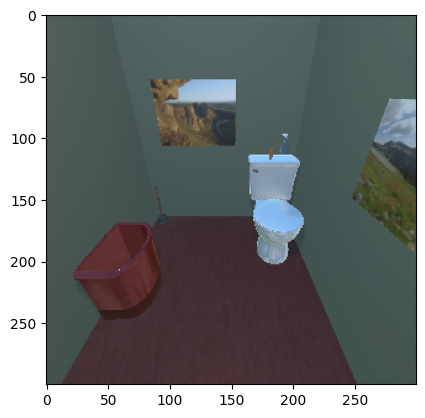

In [8]:
import matplotlib.pyplot as plt
event = controller.step("RotateLeft")
plt.imshow(event.frame)

In [9]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [10]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [11]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [12]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=88.1325, Policy=0.0077, Value=176.3534
[PPO] Epoch 10: Loss=69.8180, Policy=-0.0003, Value=139.7425
[PPO] Epoch 20: Loss=58.8034, Policy=-0.0040, Value=117.7198
[PPO] Epoch 30: Loss=50.9148, Policy=-0.0064, Value=101.9478
Approx KL Learned: 0.02158593386411667
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/100 — steps: 4096


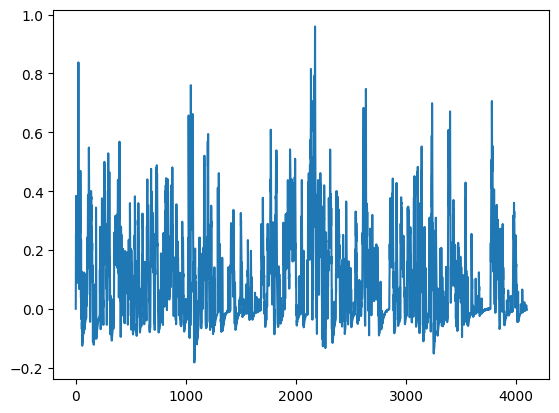

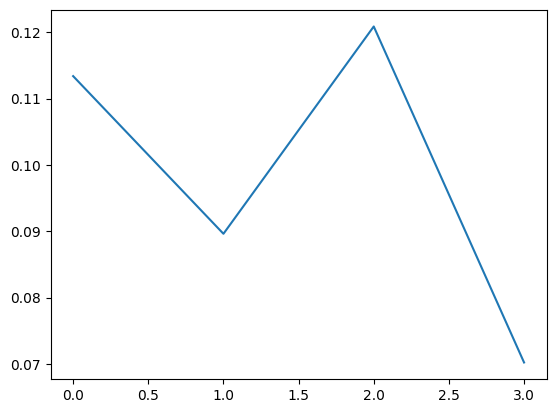

[PPO] Epoch 0: Loss=66.6938, Policy=-0.0011, Value=133.4939
[PPO] Epoch 10: Loss=57.1369, Policy=-0.0019, Value=114.3825
[PPO] Epoch 20: Loss=52.9408, Policy=-0.0079, Value=106.0009
[PPO] Epoch 30: Loss=47.9640, Policy=0.0091, Value=96.0097
Approx KL Learned: 0.022839944809675217
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/100 — steps: 4096


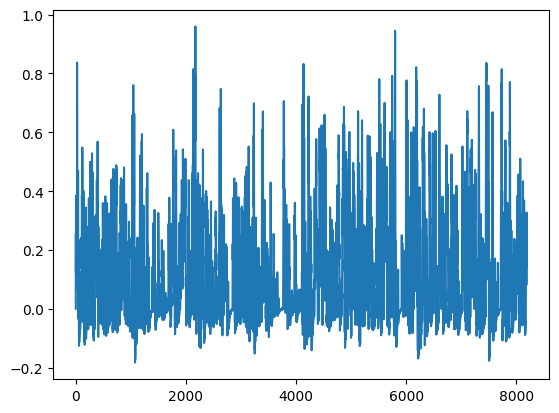

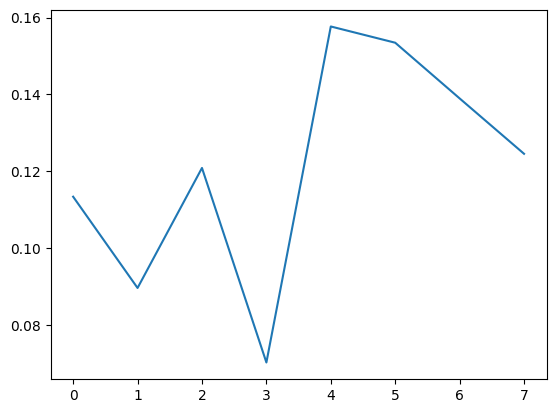

[PPO] Epoch 0: Loss=89.0429, Policy=0.0023, Value=178.1841
[PPO] Epoch 10: Loss=67.6910, Policy=0.0063, Value=135.4714
[PPO] Epoch 20: Loss=59.9726, Policy=-0.0071, Value=120.0611
[PPO] Epoch 30: Loss=56.8369, Policy=-0.0120, Value=113.7991
Approx KL Learned: 0.013498182408511639
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/100 — steps: 4096


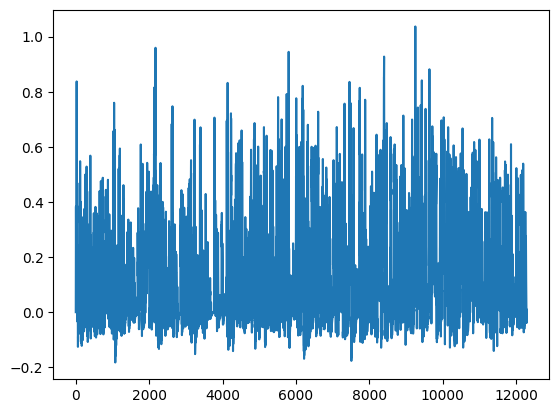

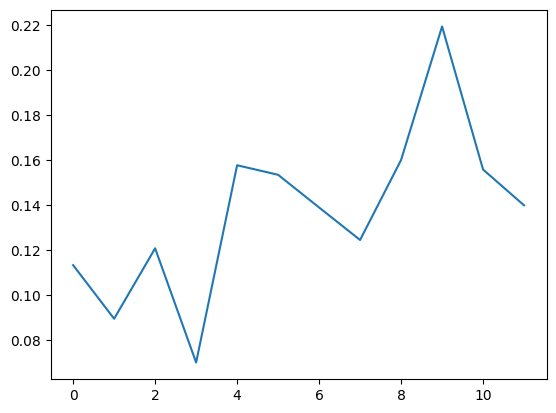

[PPO] Epoch 0: Loss=74.8212, Policy=0.0002, Value=149.7428
[PPO] Epoch 10: Loss=51.2703, Policy=-0.0070, Value=102.6544
[PPO] Epoch 20: Loss=44.1858, Policy=-0.0117, Value=88.4931
[PPO] Epoch 30: Loss=40.2279, Policy=-0.0205, Value=80.5954
Approx KL Learned: 0.016698773950338364
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/100 — steps: 4096


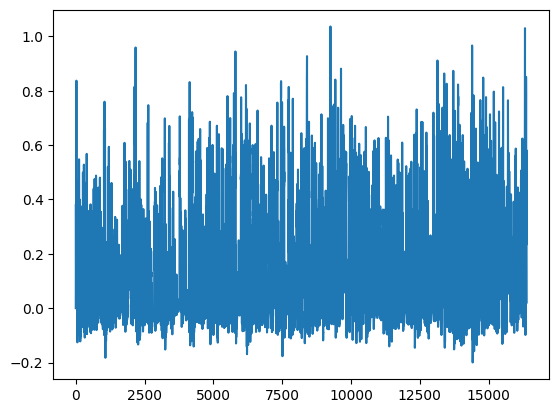

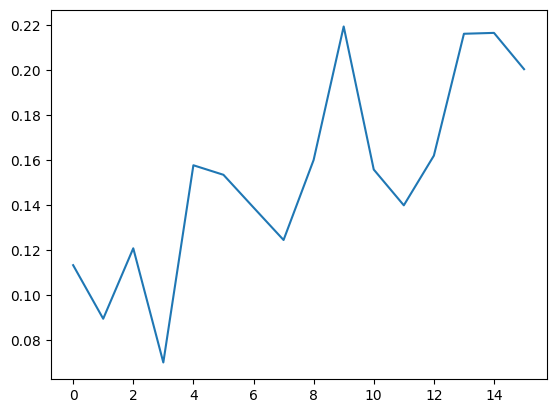

[PPO] Epoch 0: Loss=79.5268, Policy=0.0031, Value=159.1421
[PPO] Epoch 10: Loss=69.9501, Policy=-0.0001, Value=139.9946
[PPO] Epoch 20: Loss=63.1555, Policy=0.0092, Value=126.3883
[PPO] Epoch 30: Loss=55.6232, Policy=0.0657, Value=111.2108
Approx KL Learned: 0.053684234619140625
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/100 — steps: 4096


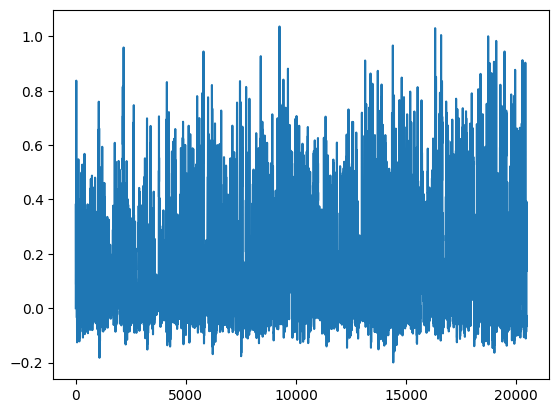

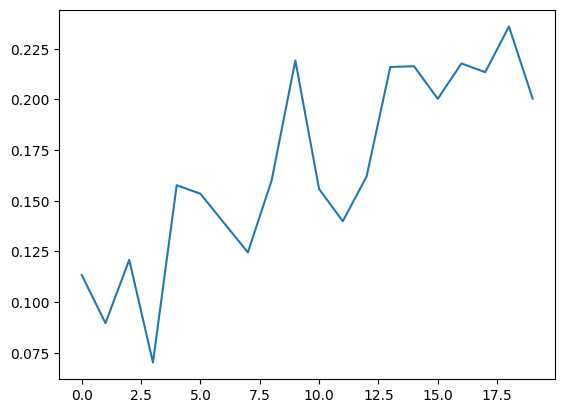

[PPO] Epoch 0: Loss=66.9414, Policy=0.0044, Value=133.9622
[PPO] Epoch 10: Loss=56.2837, Policy=-0.0068, Value=112.6671
[PPO] Epoch 20: Loss=51.8690, Policy=-0.0099, Value=103.8443
[PPO] Epoch 30: Loss=47.3573, Policy=-0.0147, Value=94.8300
Approx KL Learned: 0.019513245671987534
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/100 — steps: 4096


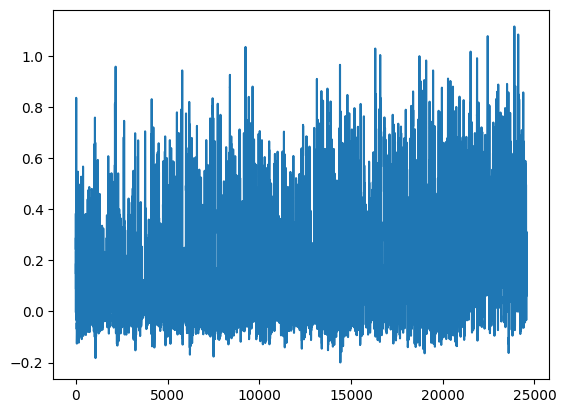

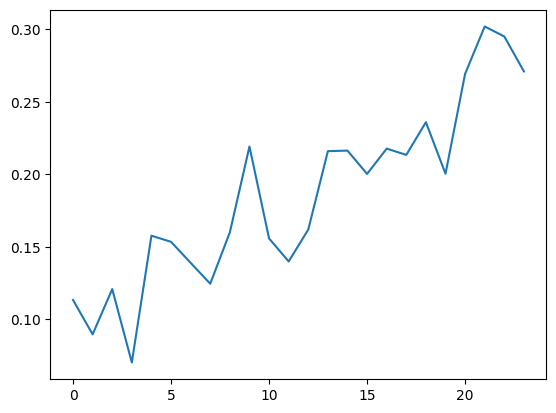

[PPO] Epoch 0: Loss=60.9875, Policy=0.0036, Value=122.0523
[PPO] Epoch 10: Loss=45.9532, Policy=-0.0066, Value=92.0000
[PPO] Epoch 20: Loss=39.6368, Policy=-0.0127, Value=79.3796
[PPO] Epoch 30: Loss=36.8743, Policy=-0.0155, Value=73.8604
Approx KL Learned: 0.01881594769656658
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/100 — steps: 4096


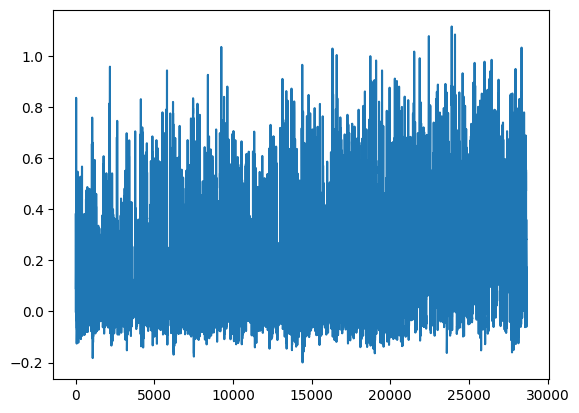

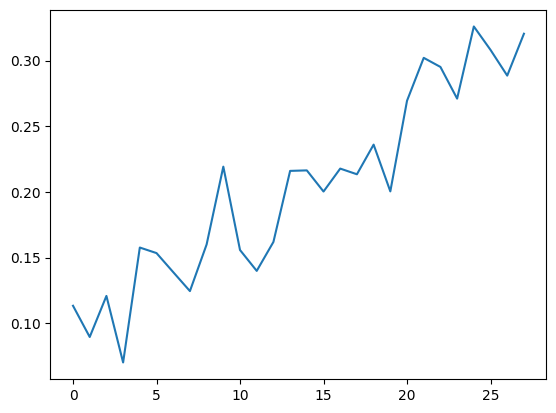

[PPO] Epoch 0: Loss=65.8026, Policy=0.0037, Value=131.6768
[PPO] Epoch 10: Loss=51.7371, Policy=-0.0057, Value=103.5632
[PPO] Epoch 20: Loss=45.5886, Policy=-0.0103, Value=91.2762
[PPO] Epoch 30: Loss=42.1134, Policy=-0.0144, Value=84.3346
Approx KL Learned: 0.02417171746492386
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/100 — steps: 4096


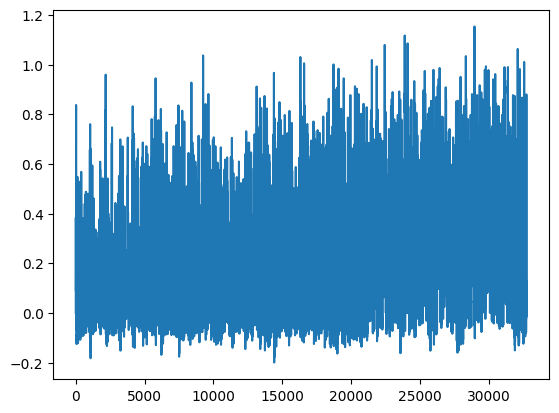

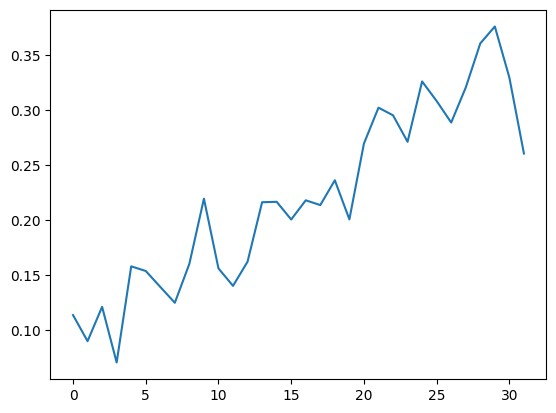

[PPO] Epoch 0: Loss=81.3498, Policy=0.0034, Value=162.7691
[PPO] Epoch 10: Loss=71.9515, Policy=-0.0004, Value=143.9832
[PPO] Epoch 20: Loss=66.9111, Policy=0.0012, Value=133.8924
[PPO] Epoch 30: Loss=64.0470, Policy=0.0052, Value=128.1542
Approx KL Learned: 0.036962367594242096
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/100 — steps: 4096


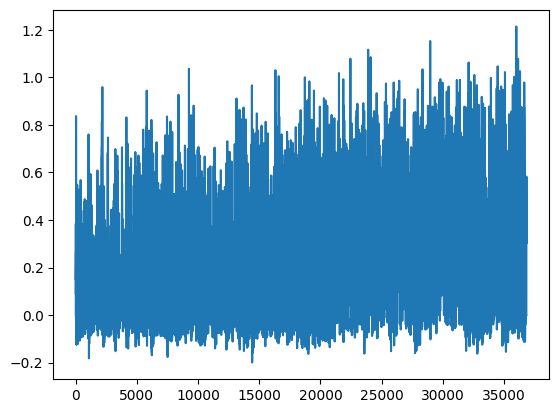

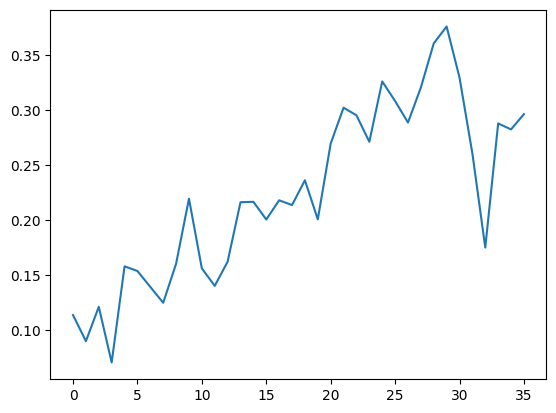

[PPO] Epoch 0: Loss=55.8608, Policy=0.0007, Value=111.7959
[PPO] Epoch 10: Loss=44.9099, Policy=-0.0062, Value=89.9059
[PPO] Epoch 20: Loss=40.8316, Policy=-0.0125, Value=81.7643
[PPO] Epoch 30: Loss=35.3445, Policy=-0.0186, Value=70.8050
Approx KL Learned: 0.022872908040881157
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/100 — steps: 4096


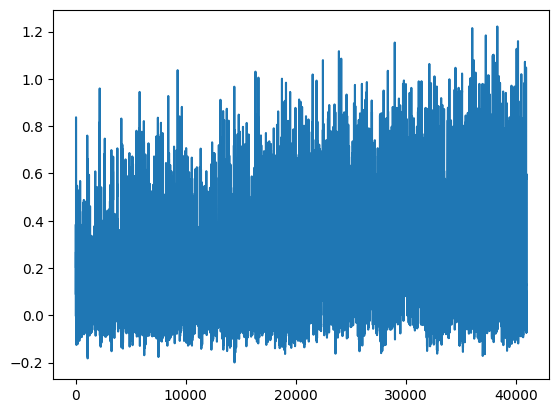

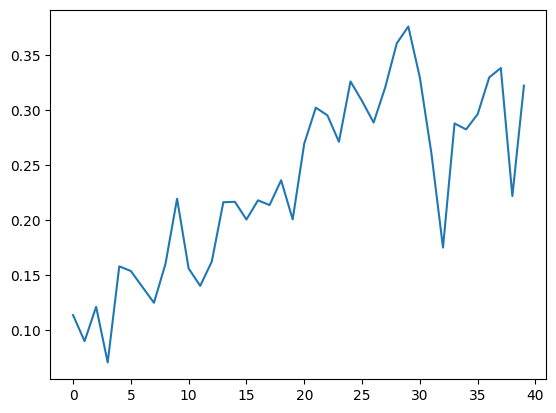

[PPO] Epoch 0: Loss=56.6979, Policy=0.0033, Value=113.4548
[PPO] Epoch 10: Loss=45.1756, Policy=-0.0057, Value=90.4266
[PPO] Epoch 20: Loss=37.5502, Policy=-0.0197, Value=75.2067
[PPO] Epoch 30: Loss=33.5049, Policy=-0.0138, Value=67.1072
Approx KL Learned: 0.028652066364884377
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 11/100 — steps: 4096


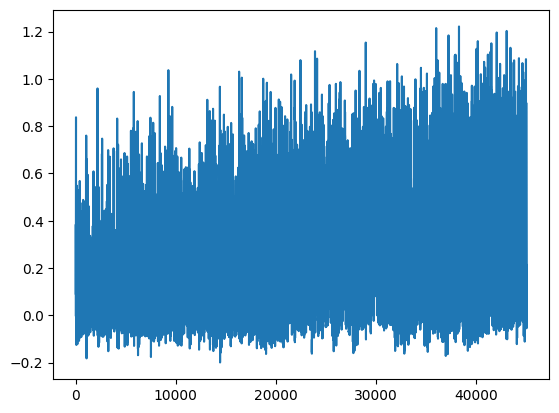

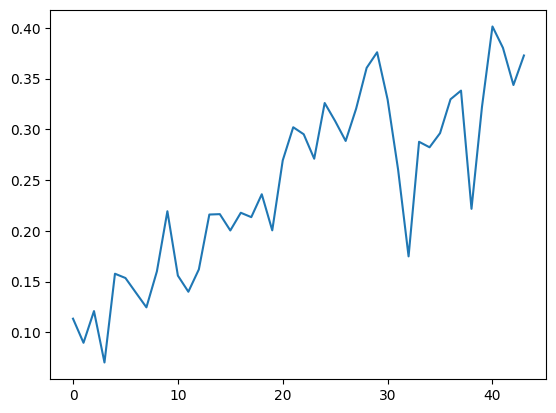

[PPO] Epoch 0: Loss=105.0008, Policy=0.0060, Value=210.0607
[PPO] Epoch 10: Loss=72.6729, Policy=-0.0012, Value=145.4220
[PPO] Epoch 20: Loss=62.8039, Policy=-0.0130, Value=125.7071
[PPO] Epoch 30: Loss=57.8725, Policy=-0.0175, Value=115.8512
Approx KL Learned: 0.02538115903735161
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 12/100 — steps: 4096


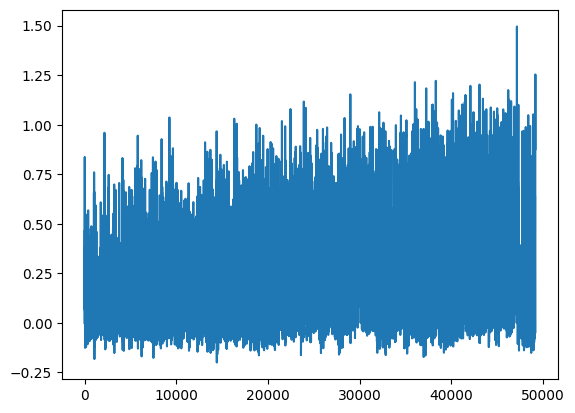

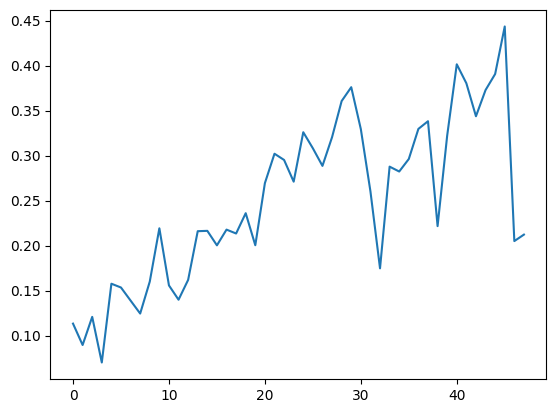

[PPO] Epoch 0: Loss=86.4725, Policy=0.0054, Value=173.0161
[PPO] Epoch 10: Loss=59.3312, Policy=-0.0035, Value=118.7510
[PPO] Epoch 20: Loss=48.4162, Policy=-0.0134, Value=96.9410
[PPO] Epoch 30: Loss=37.7810, Policy=-0.0254, Value=75.6927
Approx KL Learned: 0.03668435662984848
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 13/100 — steps: 4096


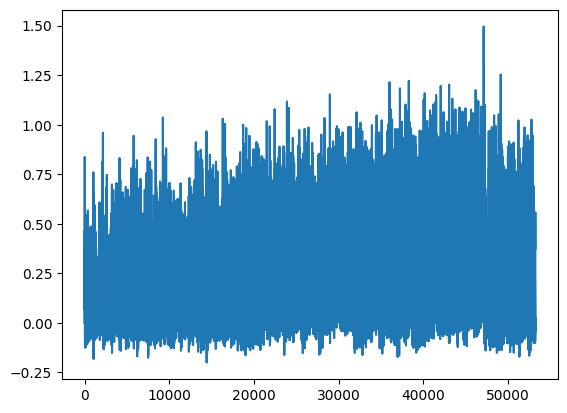

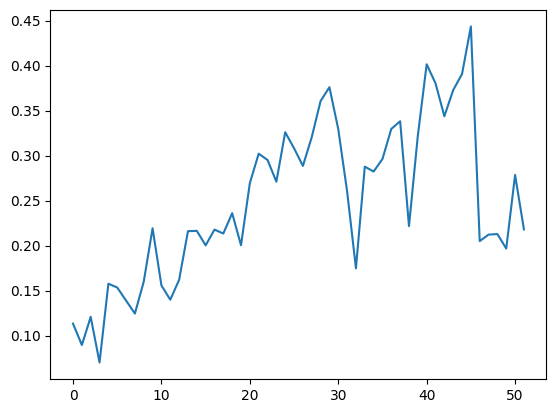

[PPO] Epoch 0: Loss=71.2878, Policy=0.0072, Value=142.6245
[PPO] Epoch 10: Loss=46.3943, Policy=-0.0017, Value=92.8583
[PPO] Epoch 20: Loss=36.2529, Policy=-0.0191, Value=72.6091
[PPO] Epoch 30: Loss=29.2314, Policy=-0.0328, Value=58.5937
Approx KL Learned: 0.0437859371304512
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 14/100 — steps: 4096


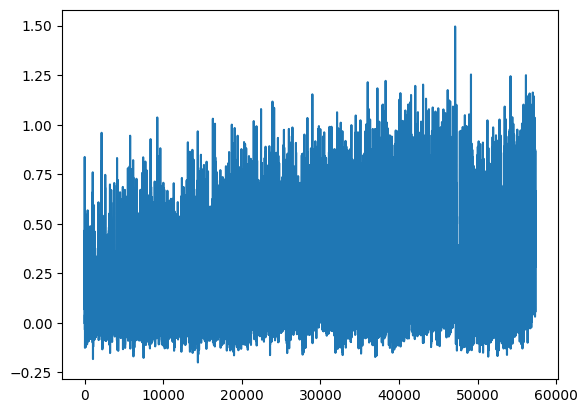

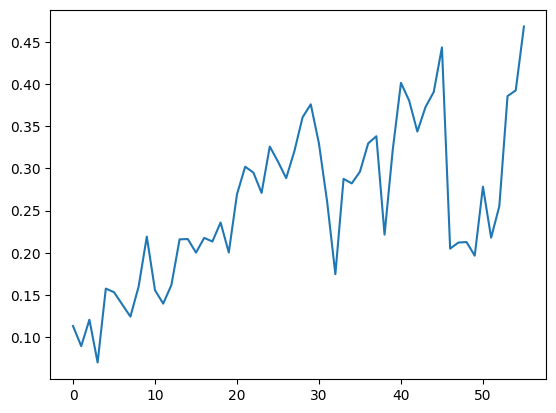

[PPO] Epoch 0: Loss=93.8563, Policy=0.0060, Value=187.7780
[PPO] Epoch 10: Loss=46.2351, Policy=-0.0074, Value=92.5640
[PPO] Epoch 20: Loss=34.7530, Policy=-0.0173, Value=69.6185
[PPO] Epoch 30: Loss=28.8285, Policy=-0.0274, Value=57.7898
Approx KL Learned: 0.03005584329366684
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 15/100 — steps: 4096


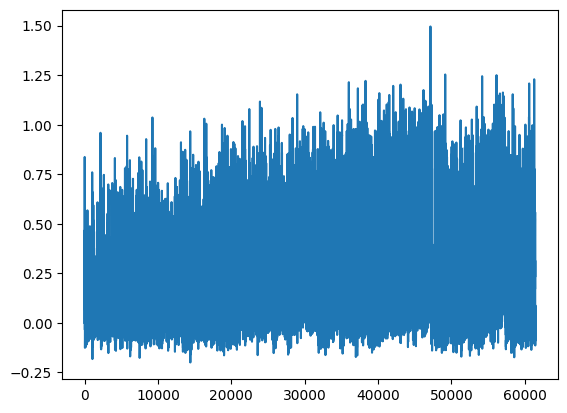

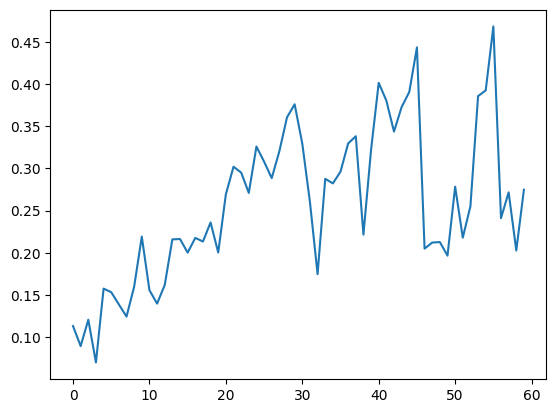

[PPO] Epoch 0: Loss=79.4553, Policy=0.0047, Value=158.9649
[PPO] Epoch 10: Loss=57.7331, Policy=0.0007, Value=115.5312
[PPO] Epoch 20: Loss=50.1367, Policy=-0.0086, Value=100.3583
[PPO] Epoch 30: Loss=41.7827, Policy=-0.0221, Value=83.6724
Approx KL Learned: 0.05093909800052643
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 16/100 — steps: 4096


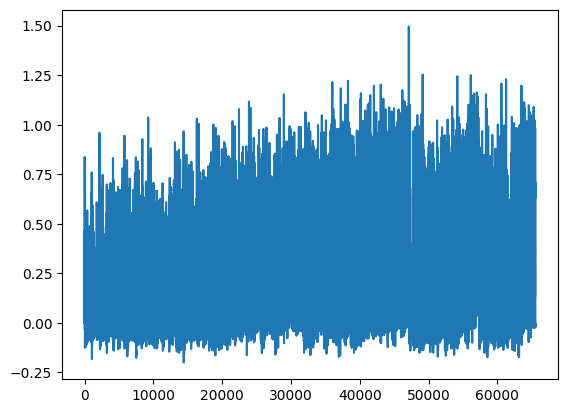

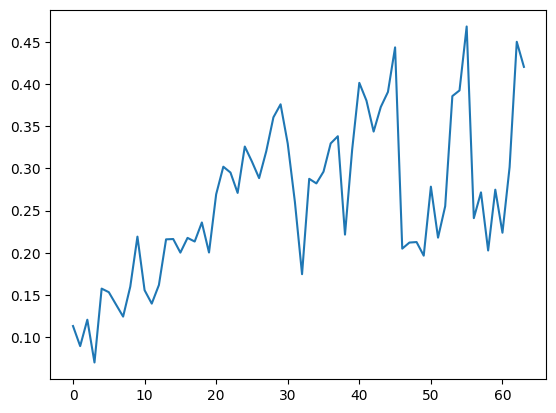

[PPO] Epoch 0: Loss=67.4723, Policy=0.0045, Value=134.9949
[PPO] Epoch 10: Loss=45.1200, Policy=-0.0010, Value=90.3019
[PPO] Epoch 20: Loss=35.9438, Policy=-0.0157, Value=71.9814
[PPO] Epoch 30: Loss=31.8413, Policy=-0.0367, Value=63.8166
Approx KL Learned: 0.057916365563869476
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 17/100 — steps: 4096


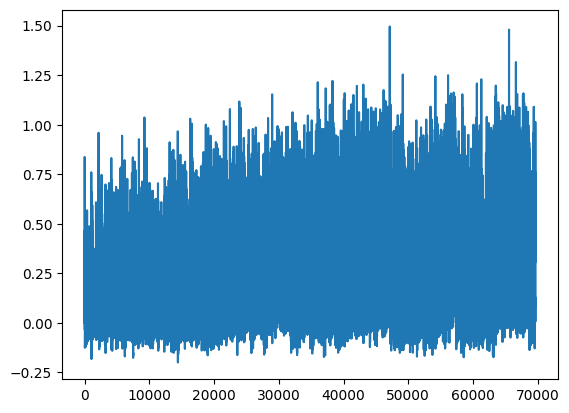

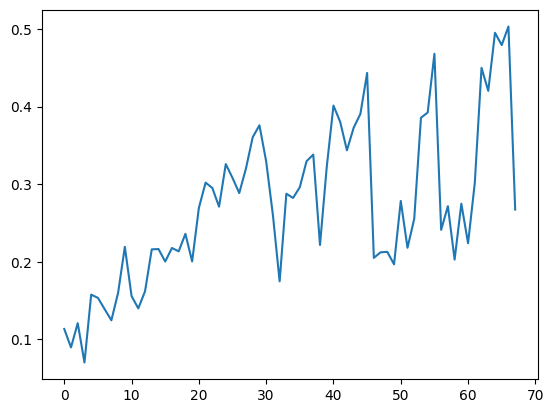

[PPO] Epoch 0: Loss=67.4165, Policy=0.0124, Value=134.8771
[PPO] Epoch 10: Loss=50.7907, Policy=-0.0056, Value=101.6580
[PPO] Epoch 20: Loss=43.5102, Policy=-0.0224, Value=87.1328
[PPO] Epoch 30: Loss=36.8915, Policy=-0.0230, Value=73.8987
Approx KL Learned: 0.05916804075241089
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 18/100 — steps: 4096


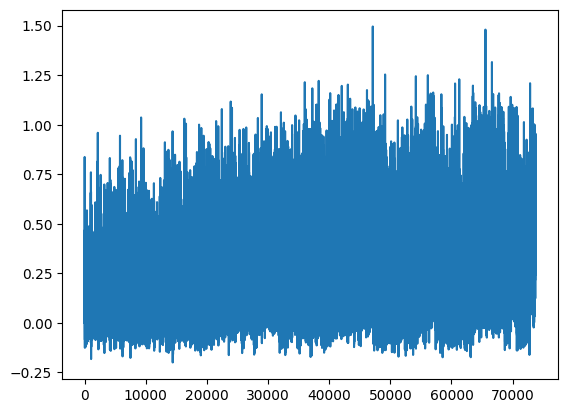

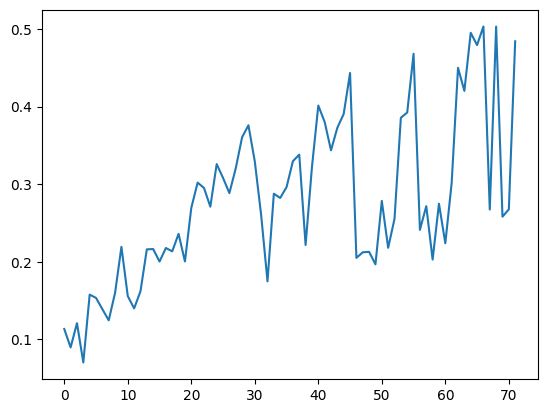

[PPO] Epoch 0: Loss=50.8467, Policy=0.0019, Value=101.7356
[PPO] Epoch 10: Loss=33.1229, Policy=-0.0031, Value=66.3004
[PPO] Epoch 20: Loss=26.8964, Policy=-0.0138, Value=53.8689
[PPO] Epoch 30: Loss=25.5364, Policy=0.0089, Value=51.1098
Approx KL Learned: 0.0776793360710144
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 19/100 — steps: 4096


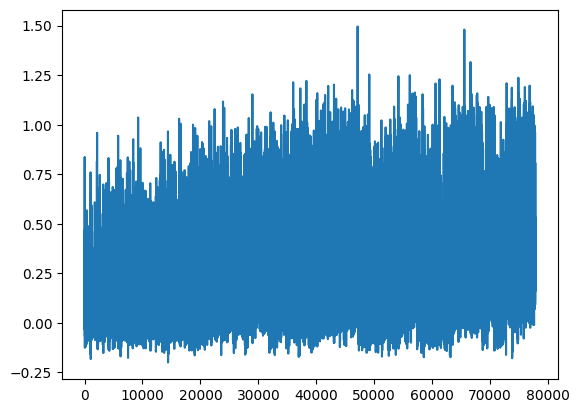

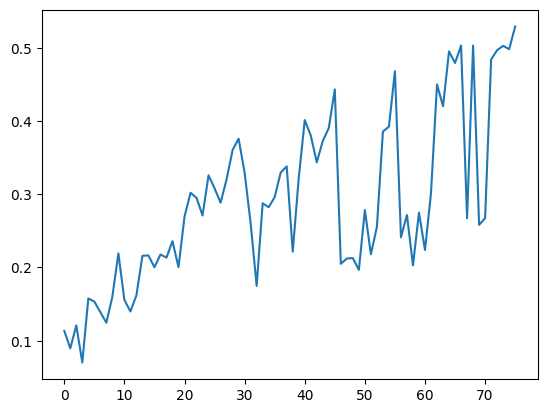

[PPO] Epoch 0: Loss=78.9021, Policy=0.0058, Value=157.8507
[PPO] Epoch 10: Loss=60.7464, Policy=0.0047, Value=121.5370
[PPO] Epoch 20: Loss=54.2560, Policy=-0.0110, Value=108.5891
[PPO] Epoch 30: Loss=48.8159, Policy=-0.0222, Value=97.7332
Approx KL Learned: 0.04271022602915764
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 20/100 — steps: 4096


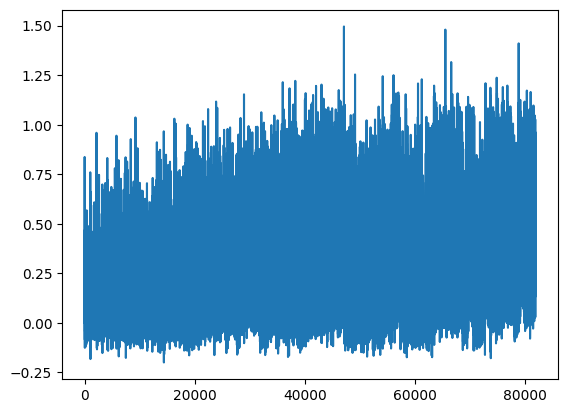

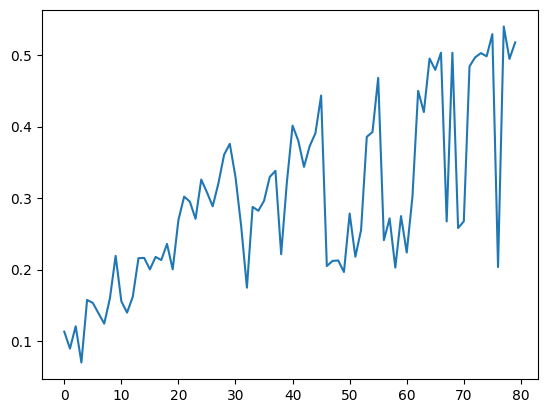

[PPO] Epoch 0: Loss=98.4071, Policy=0.0040, Value=196.8897
[PPO] Epoch 10: Loss=78.0604, Policy=-0.0056, Value=156.2143
[PPO] Epoch 20: Loss=72.9939, Policy=-0.0187, Value=146.1064
[PPO] Epoch 30: Loss=67.5347, Policy=-0.0303, Value=135.2117
Approx KL Learned: 0.03309820592403412
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 21/100 — steps: 4096


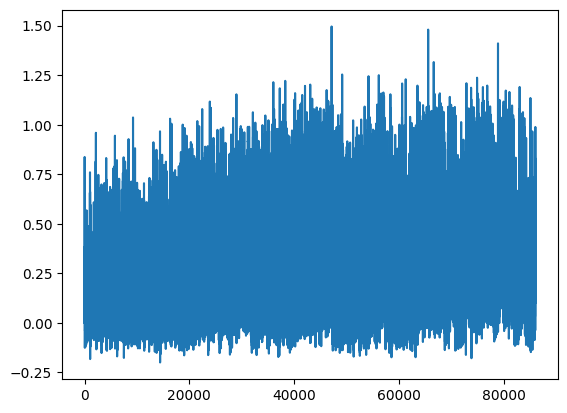

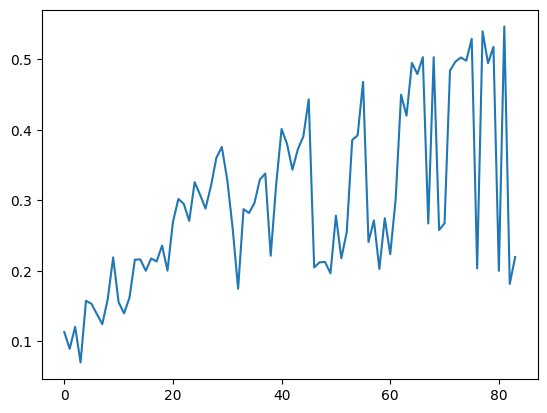

[PPO] Epoch 0: Loss=90.3459, Policy=0.0092, Value=180.7507
[PPO] Epoch 10: Loss=79.4205, Policy=-0.0031, Value=158.9253
[PPO] Epoch 20: Loss=71.4269, Policy=-0.0191, Value=142.9703
[PPO] Epoch 30: Loss=65.0302, Policy=-0.0262, Value=130.1901
Approx KL Learned: 0.04246211424469948
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 22/100 — steps: 4096


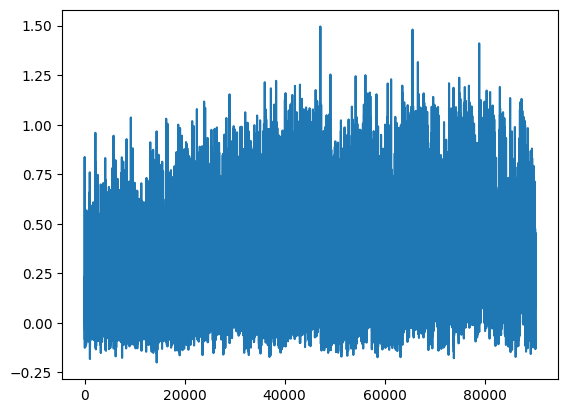

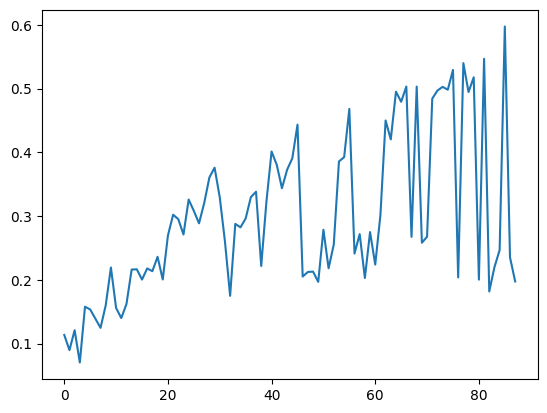

[PPO] Epoch 0: Loss=87.2736, Policy=0.0081, Value=174.6129
[PPO] Epoch 10: Loss=70.1089, Policy=-0.0014, Value=140.3029
[PPO] Epoch 20: Loss=63.3992, Policy=-0.0129, Value=126.9060
[PPO] Epoch 30: Loss=56.5506, Policy=-0.0234, Value=113.2294
Approx KL Learned: 0.044502973556518555
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 23/100 — steps: 4096


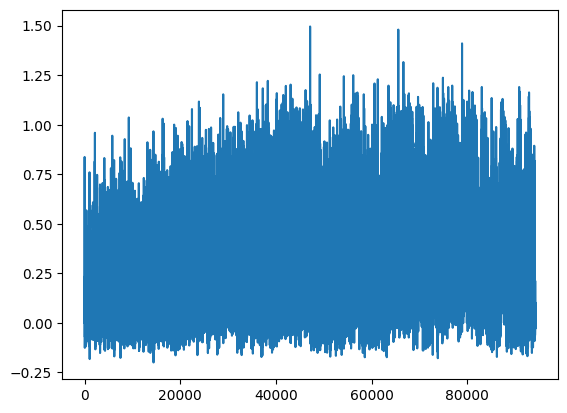

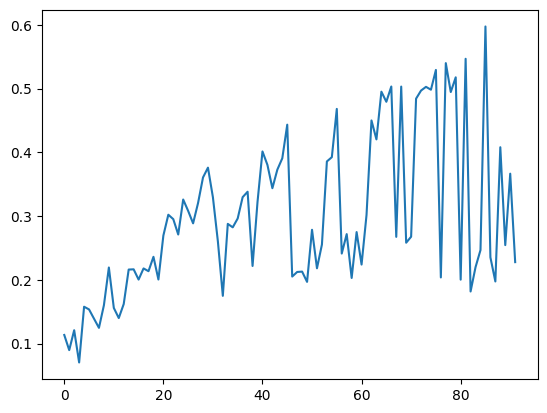

[PPO] Epoch 0: Loss=87.8209, Policy=0.0139, Value=175.6729
[PPO] Epoch 10: Loss=64.6377, Policy=0.0069, Value=129.3216
[PPO] Epoch 20: Loss=51.1993, Policy=-0.0042, Value=102.4660
[PPO] Epoch 30: Loss=43.3201, Policy=-0.0121, Value=86.7252
Approx KL Learned: 0.040961507707834244
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 24/100 — steps: 4096


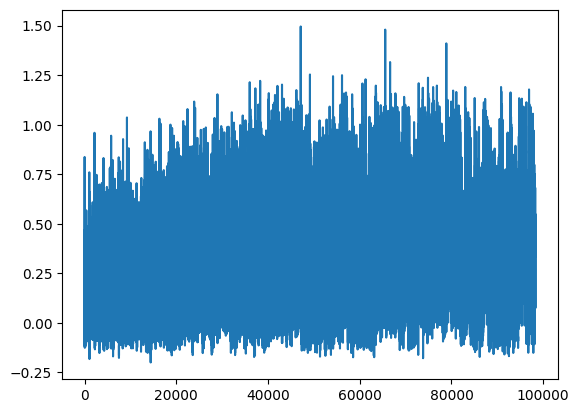

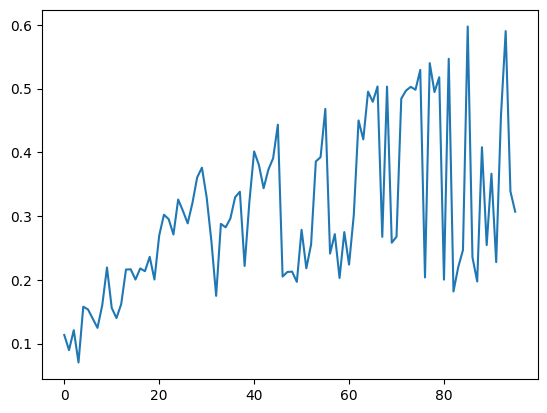

[PPO] Epoch 0: Loss=55.8287, Policy=0.0111, Value=111.6837
[PPO] Epoch 10: Loss=42.8355, Policy=-0.0053, Value=85.7330
[PPO] Epoch 20: Loss=37.4818, Policy=-0.0251, Value=75.0667
[PPO] Epoch 30: Loss=31.0639, Policy=-0.0337, Value=62.2480
Approx KL Learned: 0.07199491560459137
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 25/100 — steps: 4096


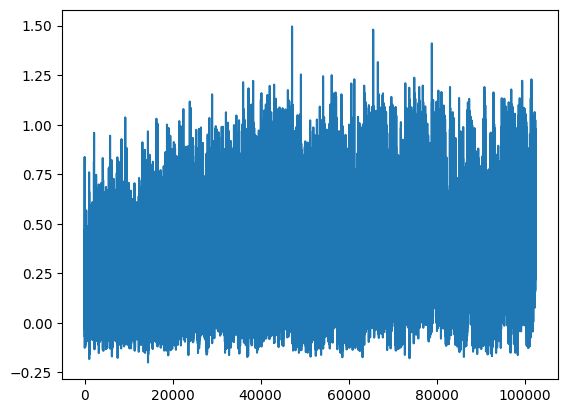

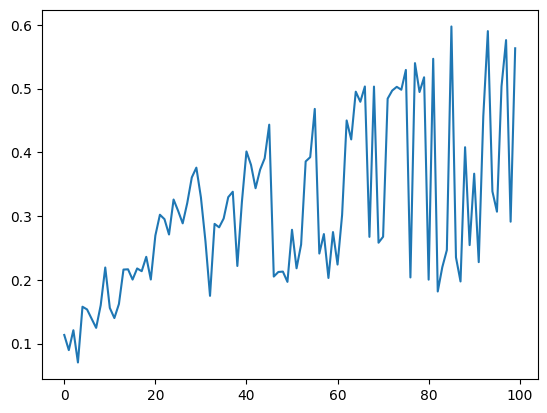

[PPO] Epoch 0: Loss=52.2691, Policy=0.0041, Value=104.5652
[PPO] Epoch 10: Loss=21.7701, Policy=-0.0005, Value=43.5778
[PPO] Epoch 20: Loss=17.8059, Policy=-0.0162, Value=35.6827
[PPO] Epoch 30: Loss=12.7087, Policy=-0.0249, Value=25.5089
Approx KL Learned: 0.06343653053045273
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 26/100 — steps: 4096


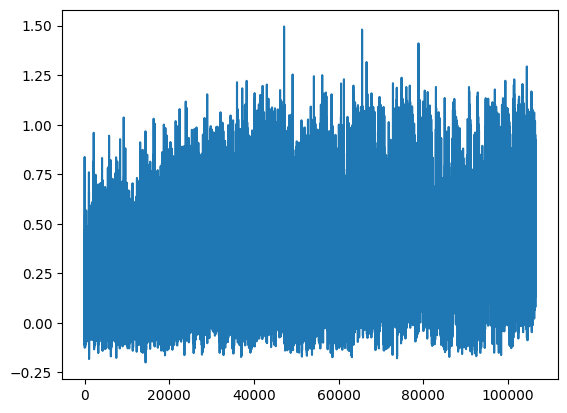

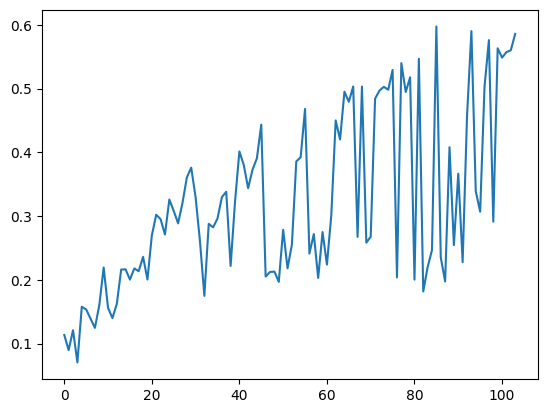

[PPO] Epoch 0: Loss=43.6822, Policy=0.0095, Value=87.3885
[PPO] Epoch 10: Loss=27.3648, Policy=-0.0043, Value=54.7815
[PPO] Epoch 20: Loss=21.9008, Policy=-0.0085, Value=43.8644
[PPO] Epoch 30: Loss=15.8127, Policy=-0.0205, Value=31.7098
Approx KL Learned: 0.04812867194414139
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 27/100 — steps: 4096


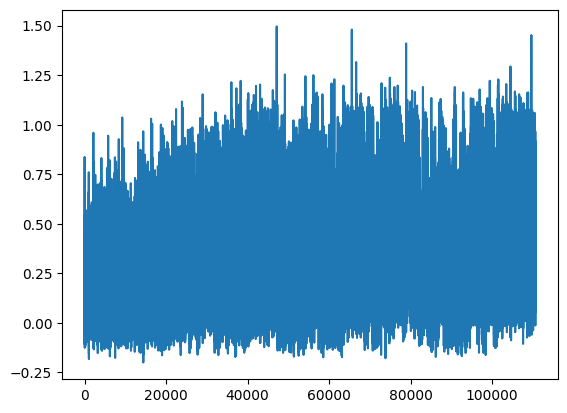

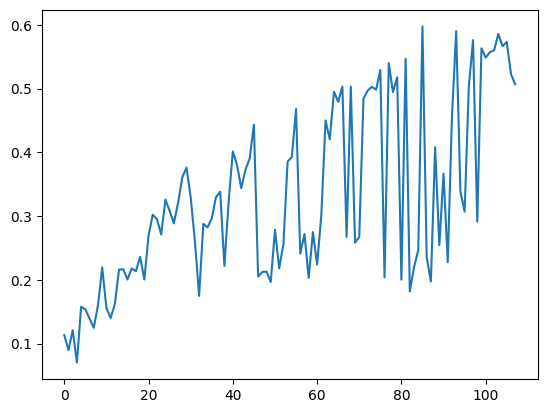

[PPO] Epoch 0: Loss=77.6613, Policy=0.0090, Value=155.3750
[PPO] Epoch 10: Loss=26.1269, Policy=-0.0051, Value=52.3328
[PPO] Epoch 20: Loss=20.9220, Policy=-0.0225, Value=41.9570
[PPO] Epoch 30: Loss=18.3671, Policy=-0.0338, Value=36.8678
Approx KL Learned: 0.05339457839727402
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 28/100 — steps: 4096


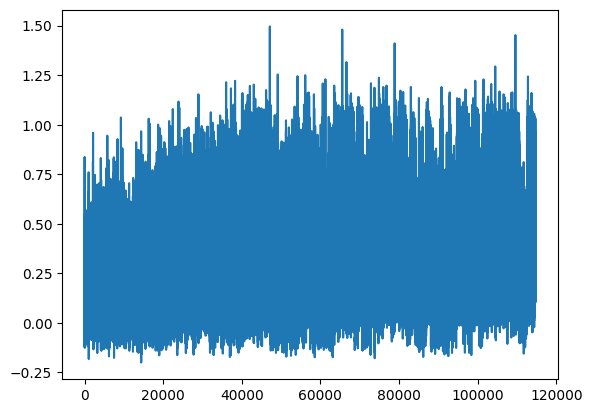

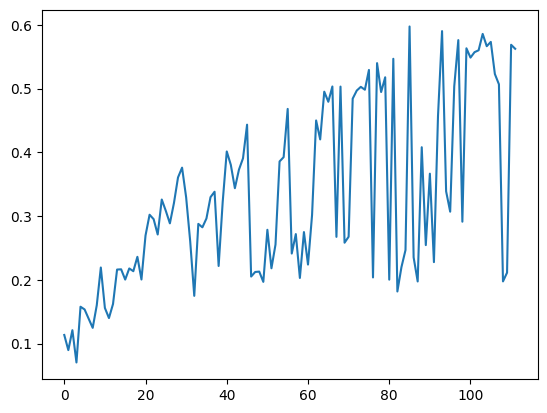

[PPO] Epoch 0: Loss=37.3357, Policy=0.0016, Value=74.6944
[PPO] Epoch 10: Loss=9.4316, Policy=-0.0029, Value=18.8921
[PPO] Epoch 20: Loss=7.0664, Policy=-0.0086, Value=14.1782
[PPO] Epoch 30: Loss=5.5944, Policy=-0.0204, Value=11.2597
Approx KL Learned: 0.12450971454381943
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 29/100 — steps: 4096


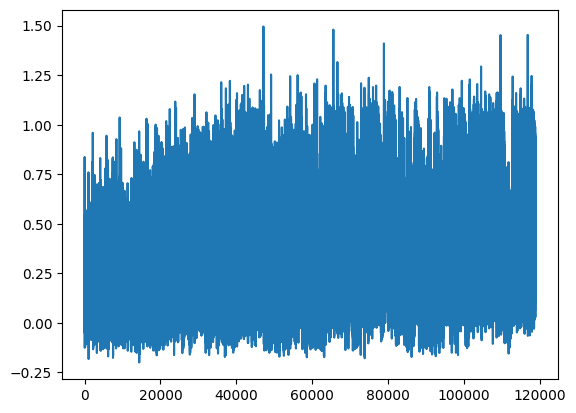

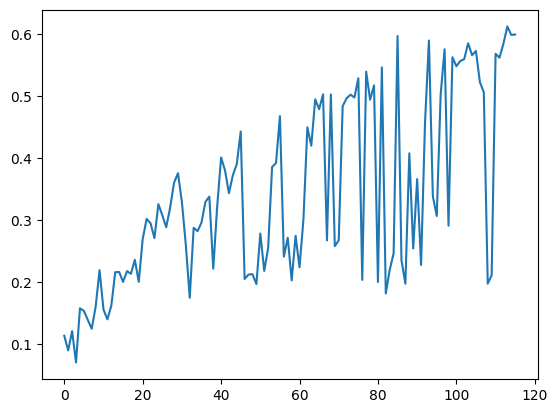

[PPO] Epoch 0: Loss=89.7655, Policy=0.0185, Value=179.5676
[PPO] Epoch 10: Loss=69.1975, Policy=0.0503, Value=138.3685
[PPO] Epoch 20: Loss=50.6412, Policy=0.0251, Value=101.3115
[PPO] Epoch 30: Loss=39.5139, Policy=0.0082, Value=79.0822
Approx KL Learned: 0.07251577824354172
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 30/100 — steps: 4096


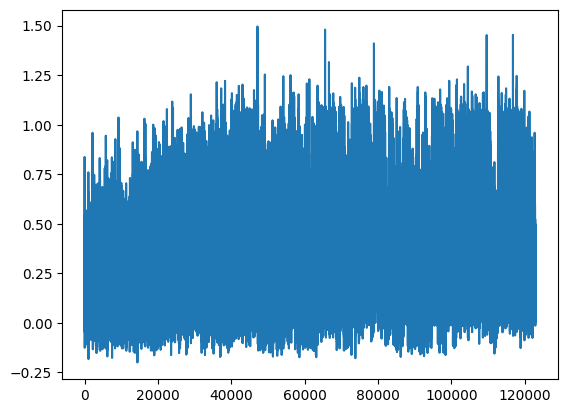

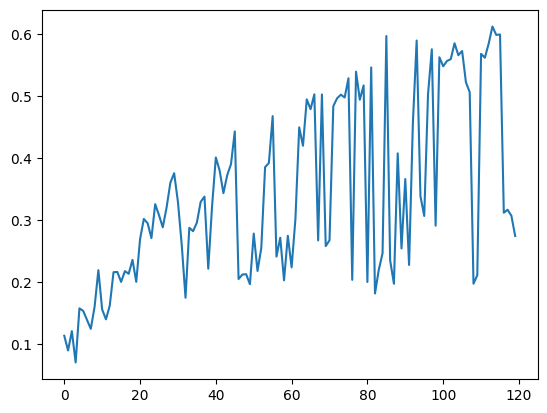

[PPO] Epoch 0: Loss=85.1199, Policy=0.0073, Value=170.3196
[PPO] Epoch 10: Loss=45.4458, Policy=-0.0017, Value=90.9894
[PPO] Epoch 20: Loss=37.9080, Policy=-0.0091, Value=75.9286
[PPO] Epoch 30: Loss=32.3154, Policy=-0.0142, Value=64.7527
Approx KL Learned: 0.024498045444488525
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 31/100 — steps: 4096


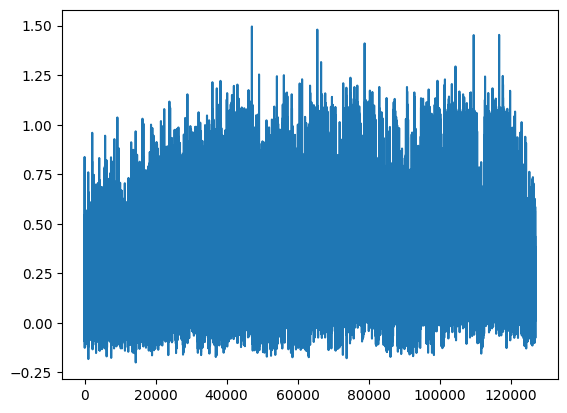

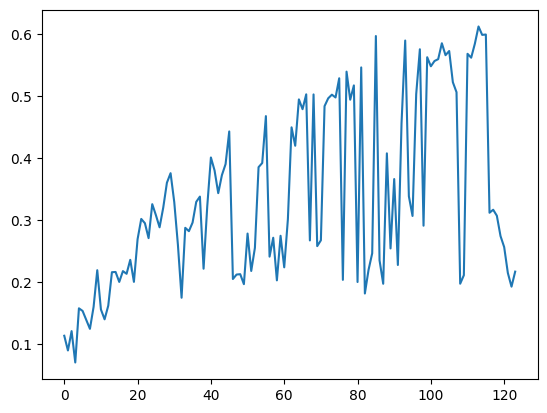

[PPO] Epoch 0: Loss=83.5953, Policy=0.0064, Value=167.2364
[PPO] Epoch 10: Loss=37.3130, Policy=-0.0071, Value=74.6970
[PPO] Epoch 20: Loss=27.6778, Policy=-0.0140, Value=55.4420
[PPO] Epoch 30: Loss=20.6746, Policy=-0.0233, Value=41.4543
Approx KL Learned: 0.04198679327964783
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 32/100 — steps: 4096


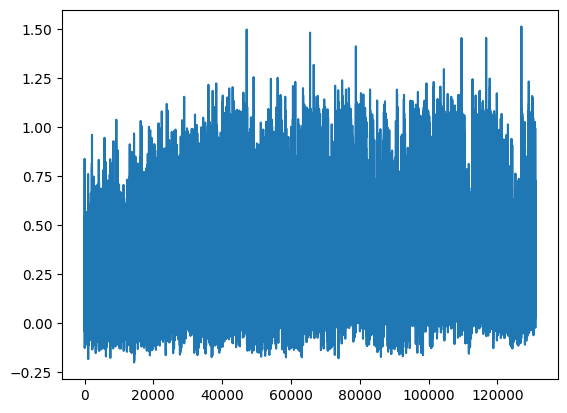

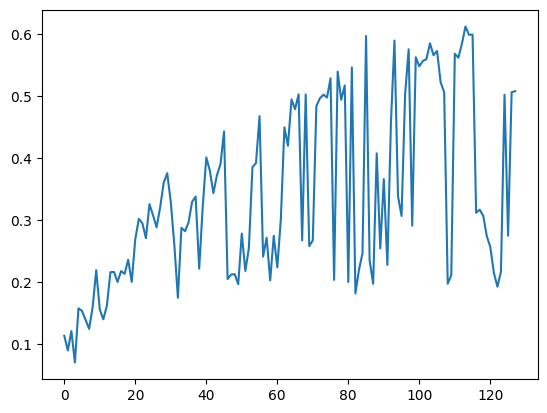

[PPO] Epoch 0: Loss=68.1382, Policy=0.0090, Value=136.3239
[PPO] Epoch 10: Loss=26.8219, Policy=-0.0026, Value=53.7116
[PPO] Epoch 20: Loss=19.6475, Policy=-0.0163, Value=39.3916
[PPO] Epoch 30: Loss=14.4979, Policy=-0.0268, Value=29.1132
Approx KL Learned: 0.04822686314582825
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 33/100 — steps: 4096


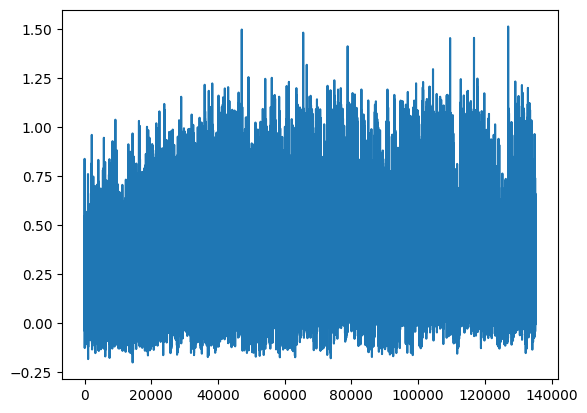

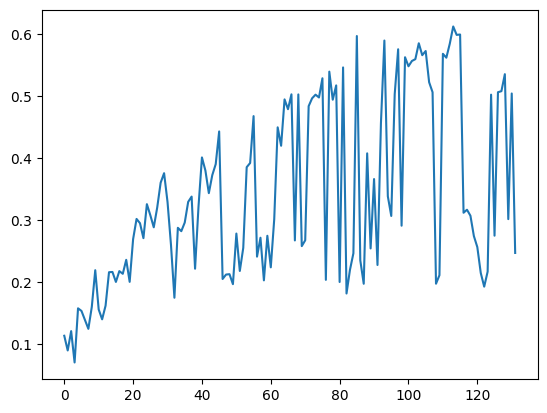

[PPO] Epoch 0: Loss=102.4130, Policy=0.0068, Value=204.8959
[PPO] Epoch 10: Loss=47.8208, Policy=-0.0006, Value=95.7251
[PPO] Epoch 20: Loss=41.0201, Policy=-0.0102, Value=82.1436
[PPO] Epoch 30: Loss=35.8940, Policy=-0.0235, Value=71.9180
Approx KL Learned: 0.03370746970176697
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 34/100 — steps: 4096


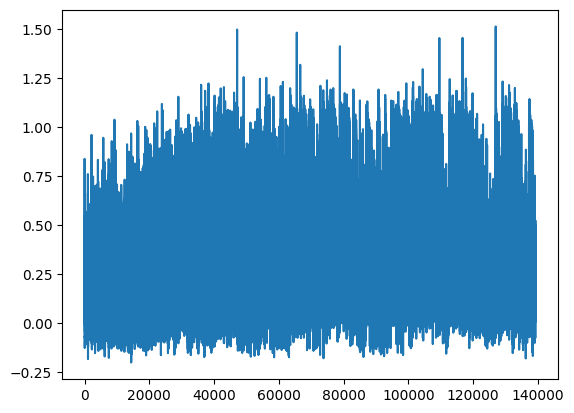

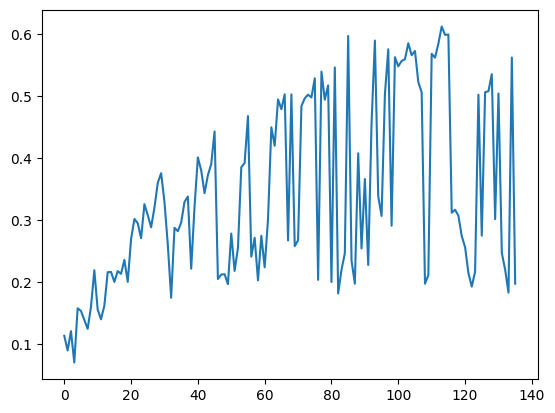

[PPO] Epoch 0: Loss=55.4493, Policy=0.0022, Value=110.9425
[PPO] Epoch 10: Loss=36.9155, Policy=-0.0014, Value=73.8844
[PPO] Epoch 20: Loss=31.4246, Policy=-0.0117, Value=62.9230
[PPO] Epoch 30: Loss=28.4032, Policy=-0.0221, Value=56.9018
Approx KL Learned: 0.059172678738832474
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 35/100 — steps: 4096


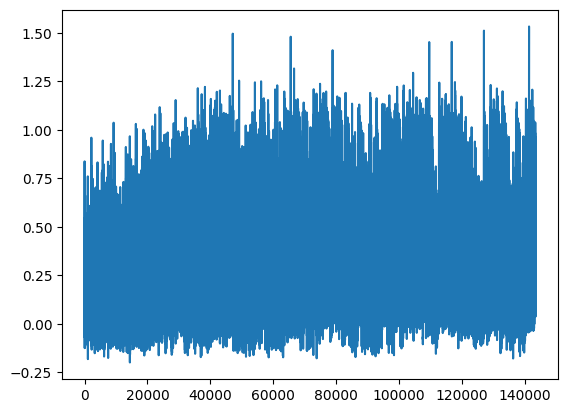

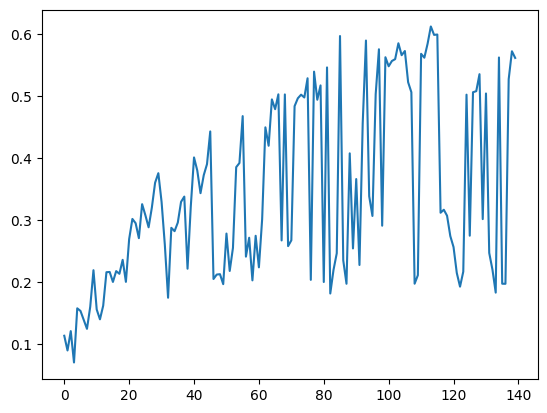

[PPO] Epoch 0: Loss=51.6285, Policy=0.0068, Value=103.2697
[PPO] Epoch 10: Loss=15.9618, Policy=0.0010, Value=31.9478
[PPO] Epoch 20: Loss=10.1527, Policy=-0.0070, Value=20.3460
[PPO] Epoch 30: Loss=9.7736, Policy=-0.0105, Value=19.6001
Approx KL Learned: 0.081876739859581
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 36/100 — steps: 4096


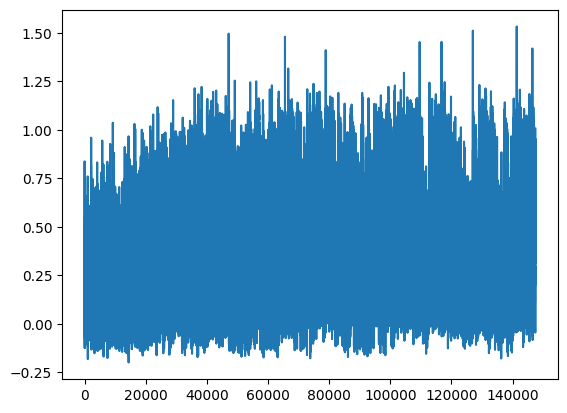

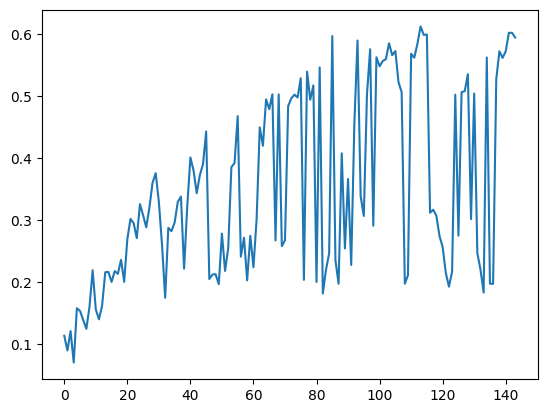

[PPO] Epoch 0: Loss=69.0217, Policy=0.0074, Value=138.0847
[PPO] Epoch 10: Loss=57.0466, Policy=0.0002, Value=114.1484
[PPO] Epoch 20: Loss=52.0680, Policy=-0.0128, Value=104.2150
[PPO] Epoch 30: Loss=47.5442, Policy=-0.0153, Value=95.1728
Approx KL Learned: 0.03410892188549042
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 37/100 — steps: 4096


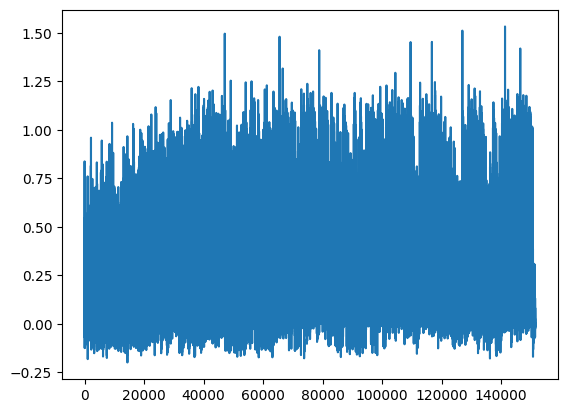

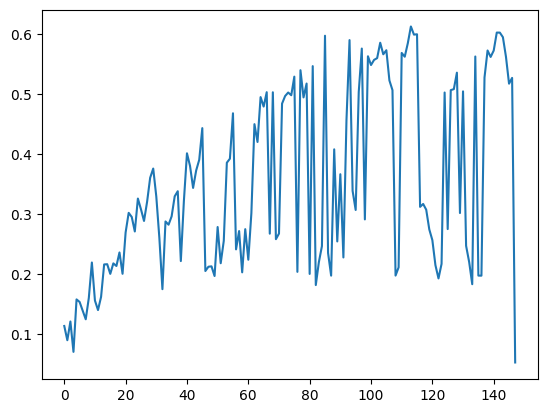

[PPO] Epoch 0: Loss=134.1729, Policy=0.0090, Value=268.4315
[PPO] Epoch 10: Loss=110.2016, Policy=-0.0038, Value=220.5139
[PPO] Epoch 20: Loss=59.0991, Policy=-0.0103, Value=118.3221
[PPO] Epoch 30: Loss=45.3037, Policy=-0.0064, Value=90.7231
Approx KL Learned: 0.018683217465877533
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 38/100 — steps: 4096


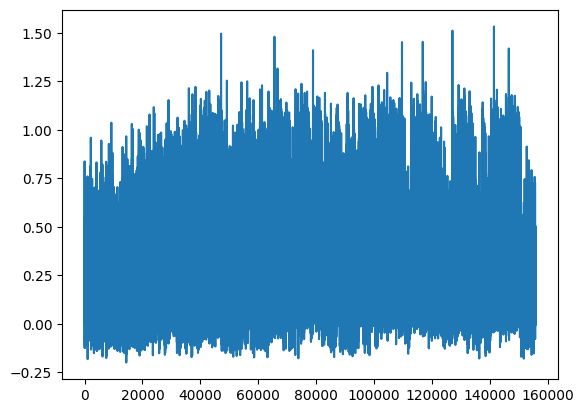

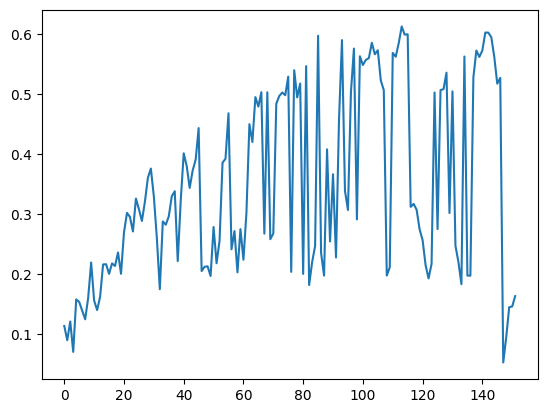

[PPO] Epoch 0: Loss=56.2616, Policy=0.0080, Value=112.5606
[PPO] Epoch 10: Loss=28.3951, Policy=-0.0087, Value=56.8592
[PPO] Epoch 20: Loss=21.7797, Policy=-0.0248, Value=43.6599
[PPO] Epoch 30: Loss=18.3010, Policy=-0.0364, Value=36.7257
Approx KL Learned: 0.055099375545978546
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 39/100 — steps: 4096


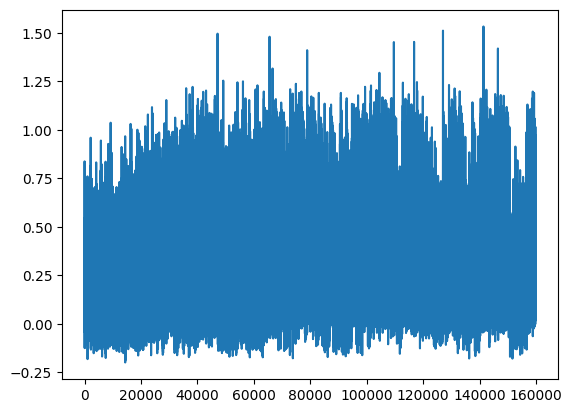

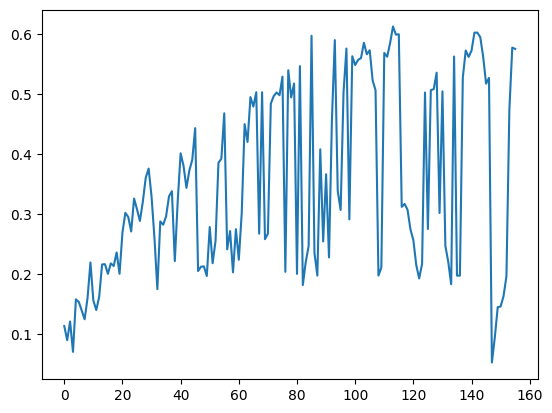

[PPO] Epoch 0: Loss=46.4112, Policy=0.0083, Value=92.8537
[PPO] Epoch 10: Loss=20.8469, Policy=0.0001, Value=41.7401
[PPO] Epoch 20: Loss=19.0695, Policy=-0.0164, Value=38.2187
[PPO] Epoch 30: Loss=16.9433, Policy=-0.0256, Value=33.9847
Approx KL Learned: 0.04639992117881775
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 40/100 — steps: 4096


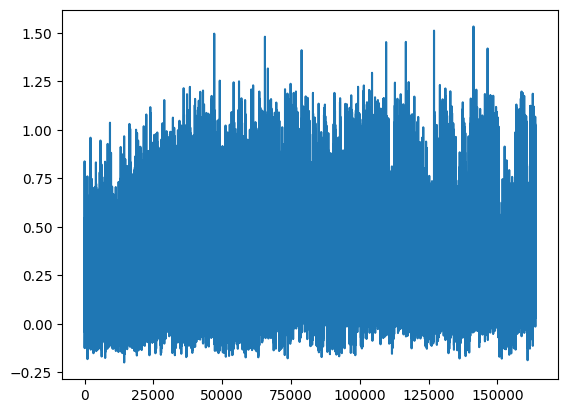

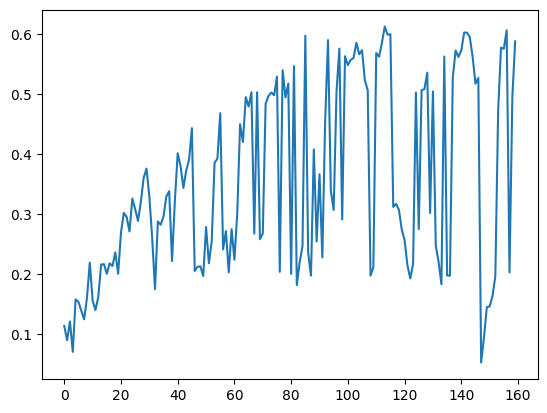

[PPO] Epoch 0: Loss=67.0603, Policy=0.0103, Value=134.1620
[PPO] Epoch 10: Loss=39.5552, Policy=0.0053, Value=79.1611
[PPO] Epoch 20: Loss=35.3951, Policy=-0.0094, Value=70.8687
[PPO] Epoch 30: Loss=32.4835, Policy=-0.0219, Value=65.0710
Approx KL Learned: 0.04207310825586319
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 41/100 — steps: 4096


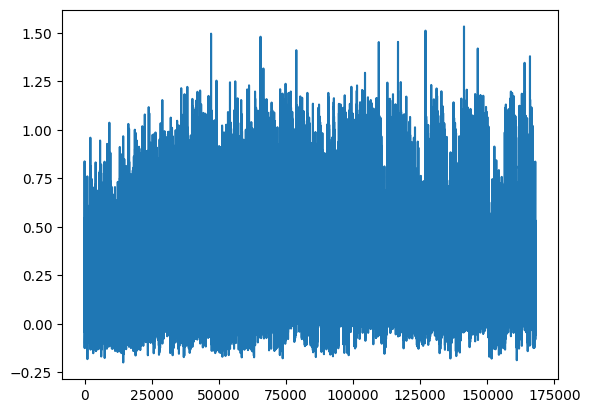

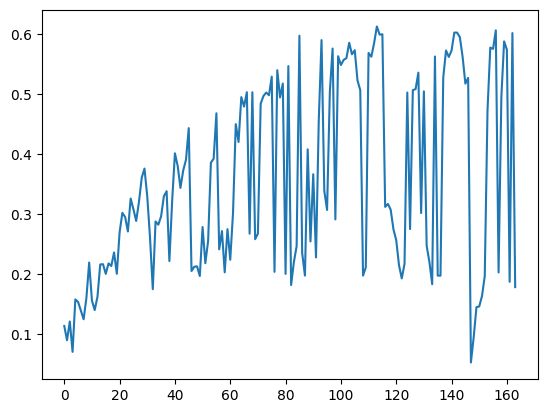

[PPO] Epoch 0: Loss=50.3196, Policy=0.0078, Value=100.6620
[PPO] Epoch 10: Loss=39.3057, Policy=-0.0023, Value=78.6546
[PPO] Epoch 20: Loss=31.8178, Policy=-0.0190, Value=63.7138
[PPO] Epoch 30: Loss=27.6883, Policy=-0.0279, Value=55.4734
Approx KL Learned: 0.05235361307859421
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 42/100 — steps: 4096


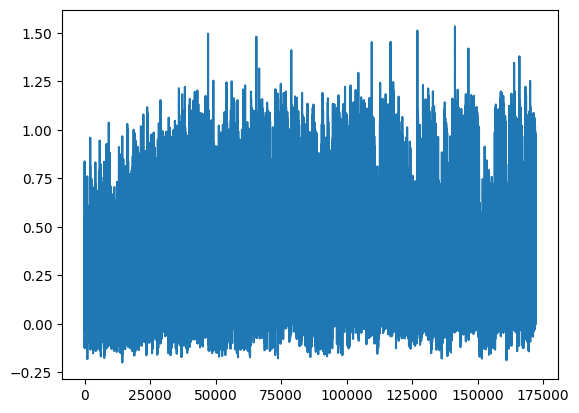

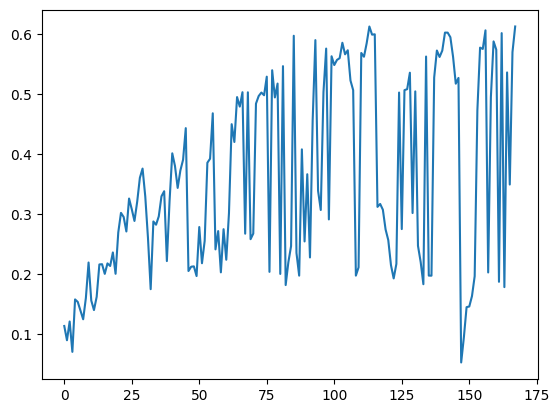

[PPO] Epoch 0: Loss=50.7380, Policy=0.0021, Value=101.4976
[PPO] Epoch 10: Loss=18.0255, Policy=0.0071, Value=36.0580
[PPO] Epoch 20: Loss=13.2572, Policy=0.0025, Value=26.5351
[PPO] Epoch 30: Loss=8.7379, Policy=-0.0046, Value=17.5116
Approx KL Learned: 0.05834038555622101
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 43/100 — steps: 4096


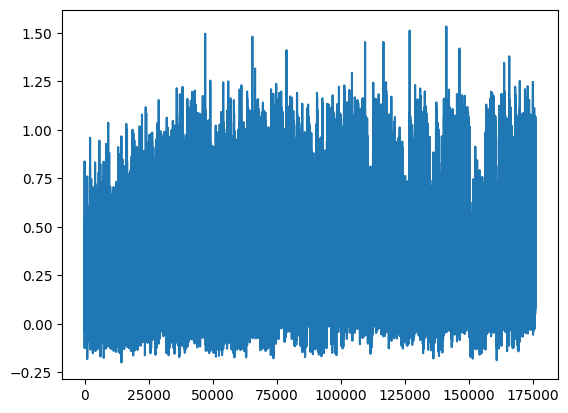

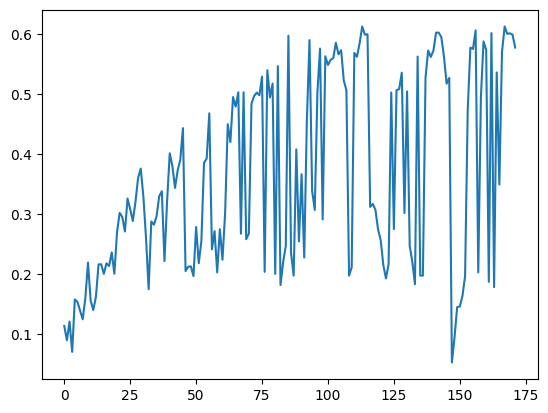

[PPO] Epoch 0: Loss=77.0869, Policy=0.0083, Value=154.1903
[PPO] Epoch 10: Loss=34.9995, Policy=0.0075, Value=70.0124
[PPO] Epoch 20: Loss=24.9511, Policy=-0.0063, Value=49.9461
[PPO] Epoch 30: Loss=20.5501, Policy=-0.0121, Value=41.1570
Approx KL Learned: 0.050307512283325195
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 44/100 — steps: 4096


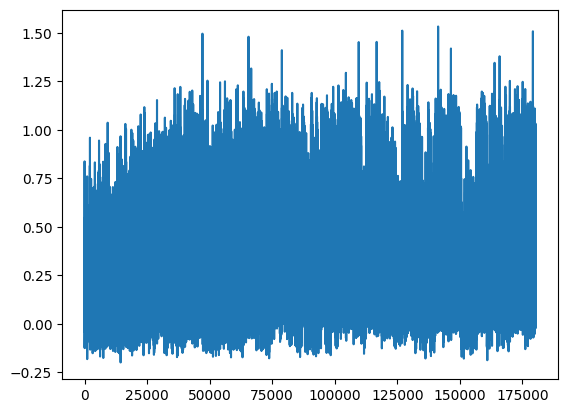

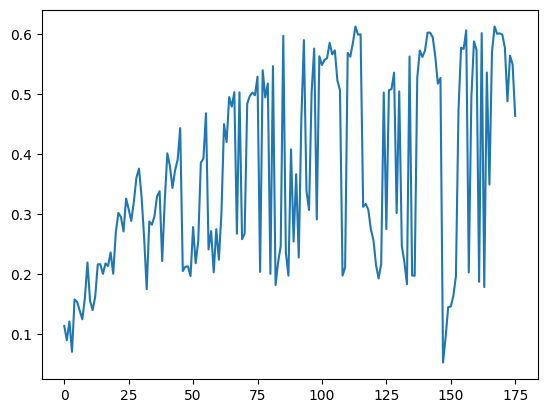

[PPO] Epoch 0: Loss=38.0445, Policy=0.0054, Value=76.1150
[PPO] Epoch 10: Loss=24.3726, Policy=-0.0082, Value=48.7984
[PPO] Epoch 20: Loss=22.2362, Policy=-0.0309, Value=44.5709
[PPO] Epoch 30: Loss=20.1187, Policy=-0.0413, Value=40.3566
Approx KL Learned: 0.059523940086364746
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 45/100 — steps: 4096


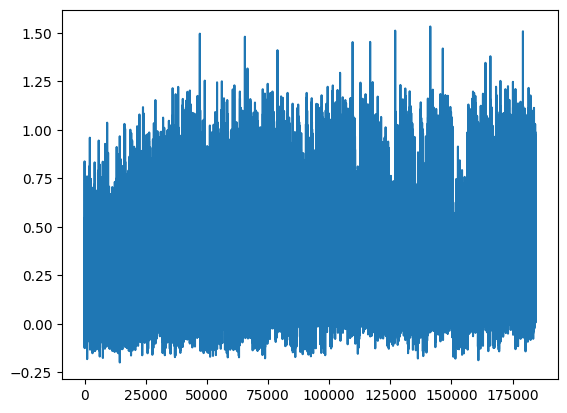

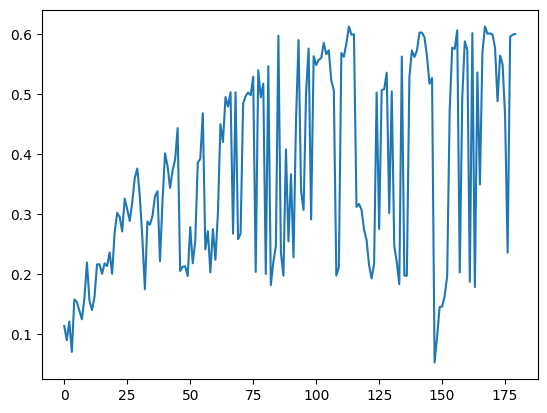

[PPO] Epoch 0: Loss=27.6234, Policy=0.0061, Value=55.2545
[PPO] Epoch 10: Loss=18.2564, Policy=-0.0020, Value=36.5346
[PPO] Epoch 20: Loss=10.4347, Policy=-0.0073, Value=20.9035
[PPO] Epoch 30: Loss=8.7811, Policy=-0.0143, Value=17.6122
Approx KL Learned: 0.036295220255851746
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 46/100 — steps: 4096


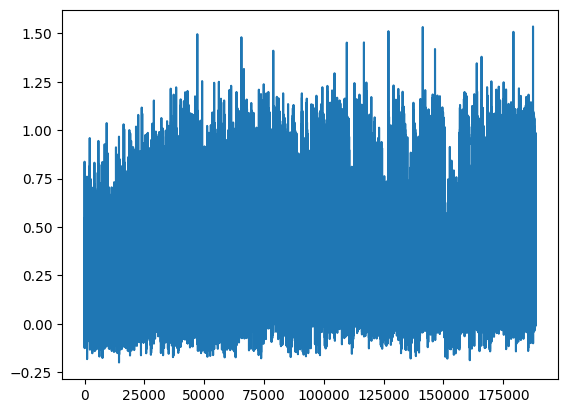

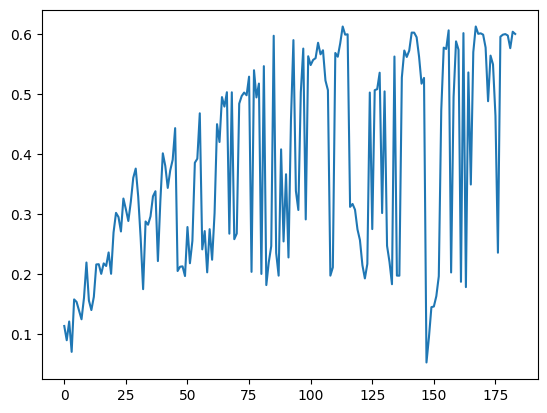

[PPO] Epoch 0: Loss=74.1850, Policy=0.0112, Value=148.3946
[PPO] Epoch 10: Loss=32.1389, Policy=0.0027, Value=64.3214
[PPO] Epoch 20: Loss=23.7687, Policy=-0.0164, Value=47.6189
[PPO] Epoch 30: Loss=16.9164, Policy=-0.0307, Value=33.9419
Approx KL Learned: 0.05212268605828285
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 47/100 — steps: 4096


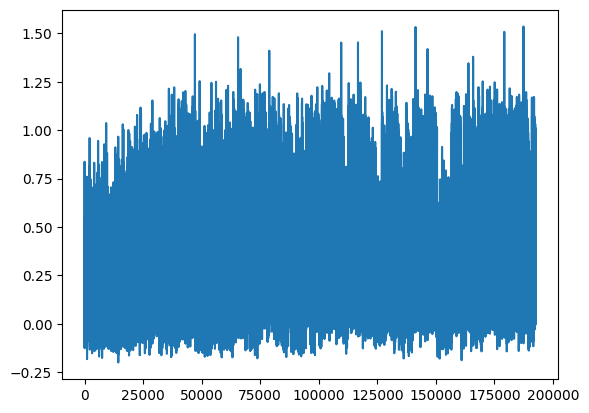

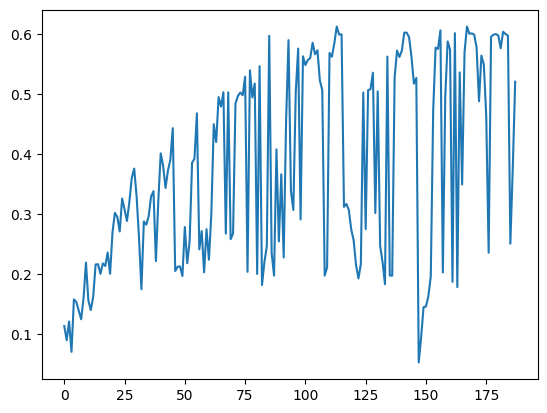

[PPO] Epoch 0: Loss=28.1422, Policy=0.0075, Value=56.3031
[PPO] Epoch 10: Loss=23.0282, Policy=-0.0169, Value=46.1277
[PPO] Epoch 20: Loss=21.0137, Policy=-0.0353, Value=42.1341
[PPO] Epoch 30: Loss=19.3596, Policy=-0.0469, Value=38.8490
Approx KL Learned: 0.07239066064357758
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 48/100 — steps: 4096


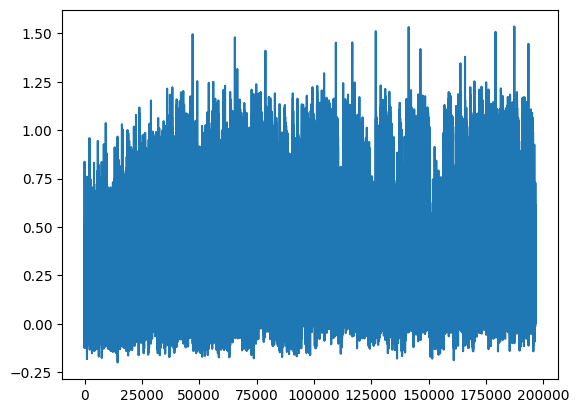

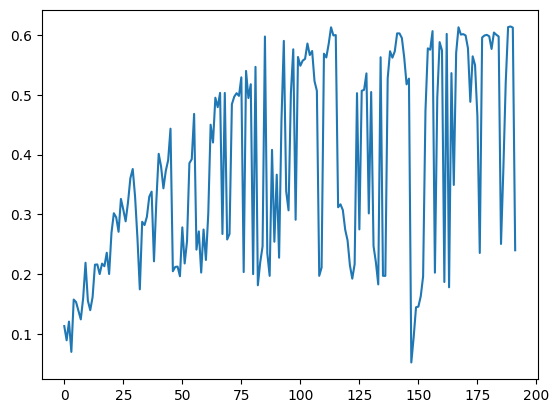

[PPO] Epoch 0: Loss=64.5051, Policy=0.0075, Value=129.0526
[PPO] Epoch 10: Loss=31.7112, Policy=0.0039, Value=63.4726
[PPO] Epoch 20: Loss=28.6695, Policy=-0.0108, Value=57.4181
[PPO] Epoch 30: Loss=26.0200, Policy=-0.0204, Value=52.1381
Approx KL Learned: 0.04385286942124367
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 49/100 — steps: 4096


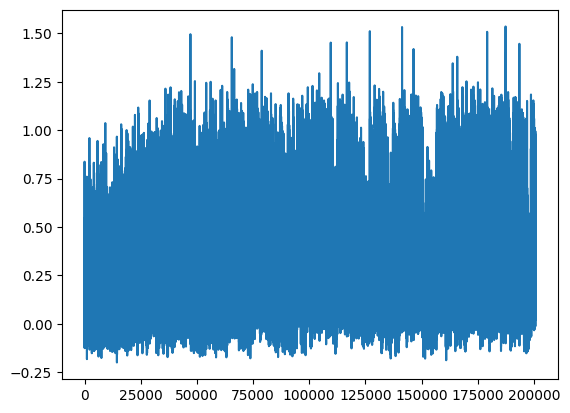

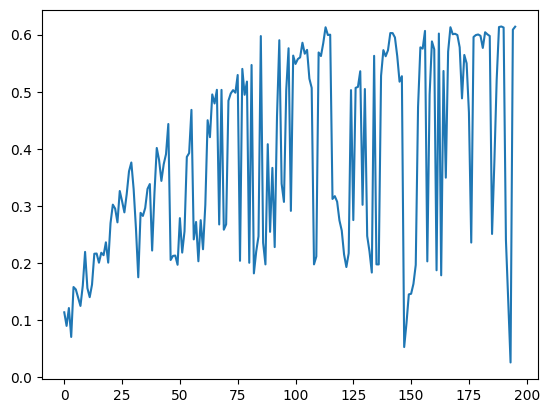

[PPO] Epoch 0: Loss=52.4478, Policy=0.0115, Value=104.9305
[PPO] Epoch 10: Loss=29.3036, Policy=0.0000, Value=58.6657
[PPO] Epoch 20: Loss=23.8469, Policy=-0.0222, Value=47.7959
[PPO] Epoch 30: Loss=18.4683, Policy=-0.0337, Value=37.0614
Approx KL Learned: 0.051243267953395844
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 50/100 — steps: 4096


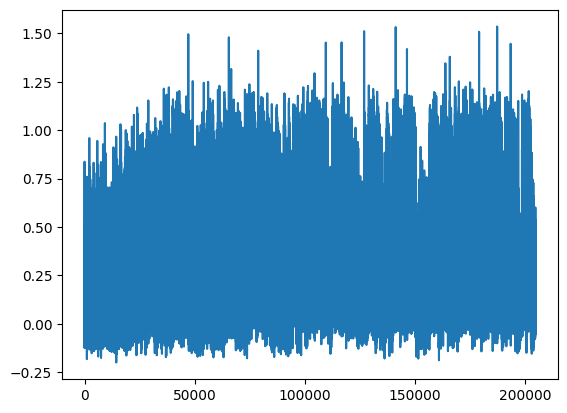

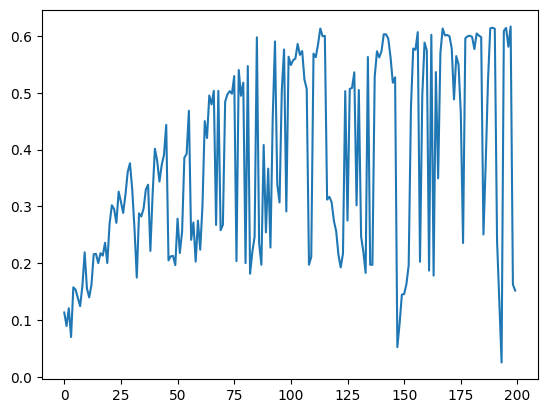

[PPO] Epoch 0: Loss=85.0723, Policy=0.0053, Value=170.2110
[PPO] Epoch 10: Loss=55.5828, Policy=0.0002, Value=111.2427
[PPO] Epoch 20: Loss=42.1684, Policy=-0.0121, Value=84.4392
[PPO] Epoch 30: Loss=35.8801, Policy=-0.0258, Value=71.8877
Approx KL Learned: 0.035398341715335846
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 51/100 — steps: 4096


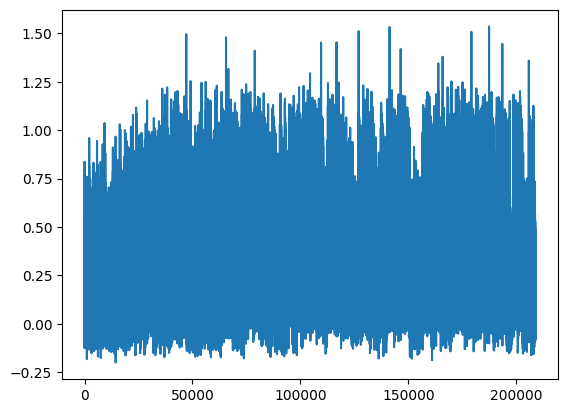

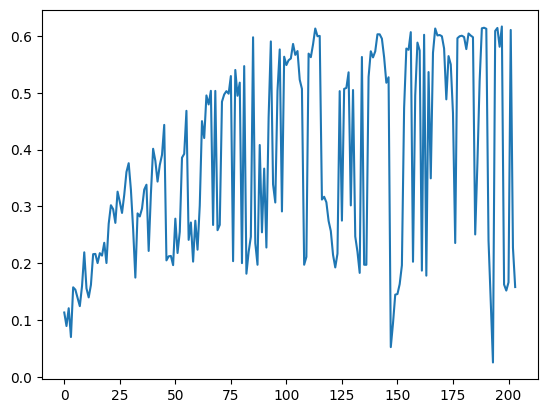

[PPO] Epoch 0: Loss=46.1410, Policy=0.0086, Value=92.3110
[PPO] Epoch 10: Loss=30.3790, Policy=-0.0007, Value=60.8064
[PPO] Epoch 20: Loss=26.5757, Policy=-0.0137, Value=53.2265
[PPO] Epoch 30: Loss=22.8494, Policy=-0.0249, Value=45.7990
Approx KL Learned: 0.07291990518569946
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 52/100 — steps: 4096


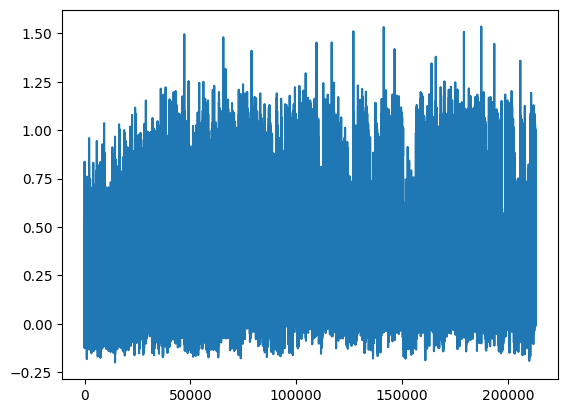

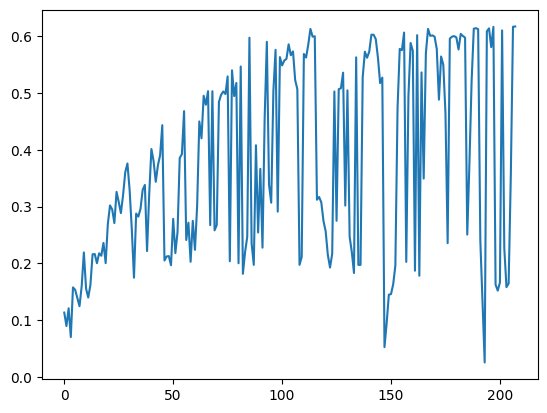

[PPO] Epoch 0: Loss=95.7543, Policy=0.0066, Value=191.5347
[PPO] Epoch 10: Loss=40.2256, Policy=0.0099, Value=80.4733
[PPO] Epoch 20: Loss=26.0542, Policy=-0.0059, Value=52.1605
[PPO] Epoch 30: Loss=20.4020, Policy=-0.0171, Value=40.8795
Approx KL Learned: 0.04054861143231392
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 53/100 — steps: 4096


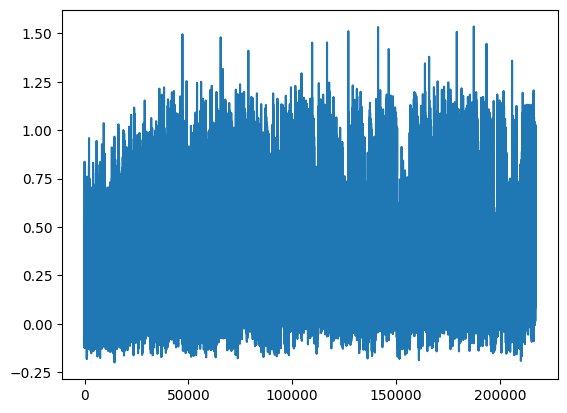

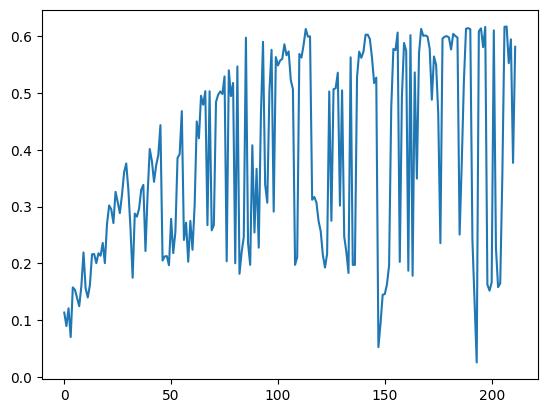

[PPO] Epoch 0: Loss=58.5305, Policy=0.0169, Value=117.0659
[PPO] Epoch 10: Loss=27.0178, Policy=0.0007, Value=54.0703
[PPO] Epoch 20: Loss=21.3914, Policy=-0.0112, Value=42.8422
[PPO] Epoch 30: Loss=17.1465, Policy=-0.0196, Value=34.3714
Approx KL Learned: 0.026417201384902
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 54/100 — steps: 4096


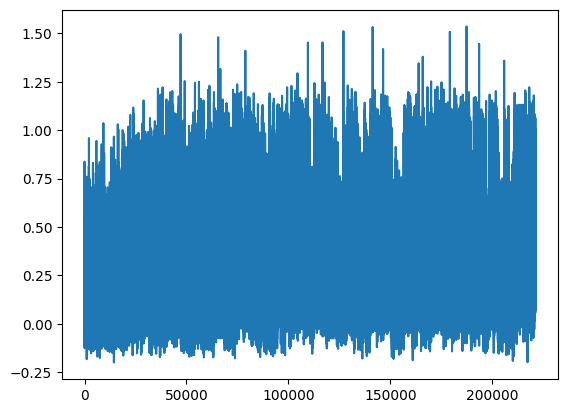

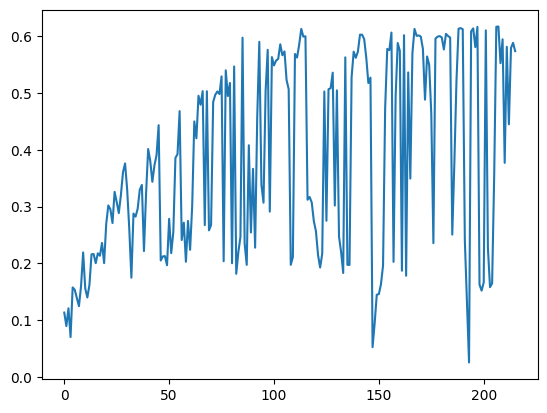

[PPO] Epoch 0: Loss=85.0741, Policy=0.0043, Value=170.1866
[PPO] Epoch 10: Loss=41.3461, Policy=0.0040, Value=82.7323
[PPO] Epoch 20: Loss=24.7602, Policy=-0.0157, Value=49.5978
[PPO] Epoch 30: Loss=20.7111, Policy=-0.0259, Value=41.5210
Approx KL Learned: 0.04853849485516548
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 55/100 — steps: 4096


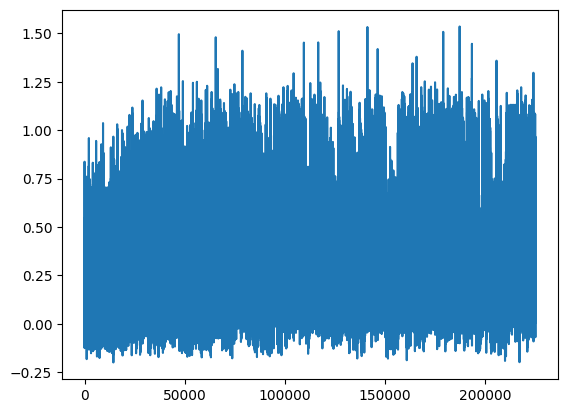

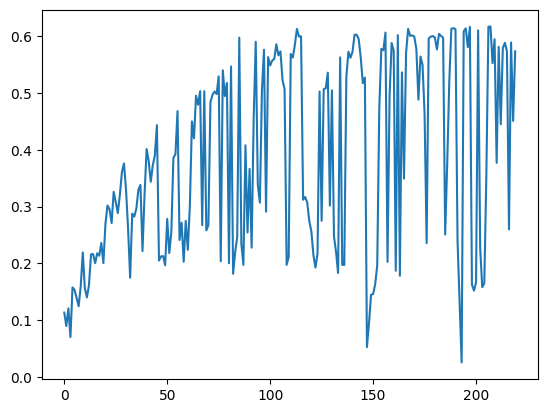

[PPO] Epoch 0: Loss=38.5464, Policy=0.0070, Value=77.1135
[PPO] Epoch 10: Loss=15.8281, Policy=-0.0017, Value=31.6920
[PPO] Epoch 20: Loss=12.6549, Policy=-0.0122, Value=25.3683
[PPO] Epoch 30: Loss=10.7648, Policy=-0.0193, Value=21.6030
Approx KL Learned: 0.03726387023925781
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 56/100 — steps: 4096


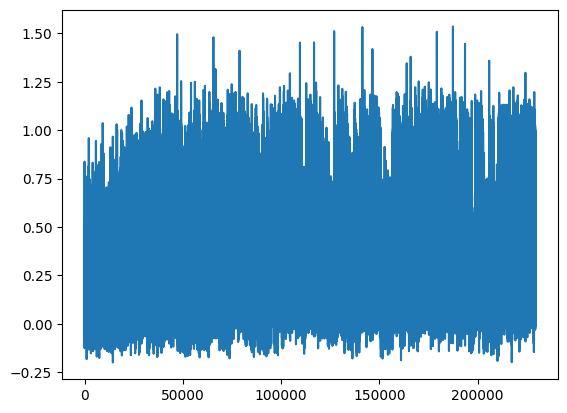

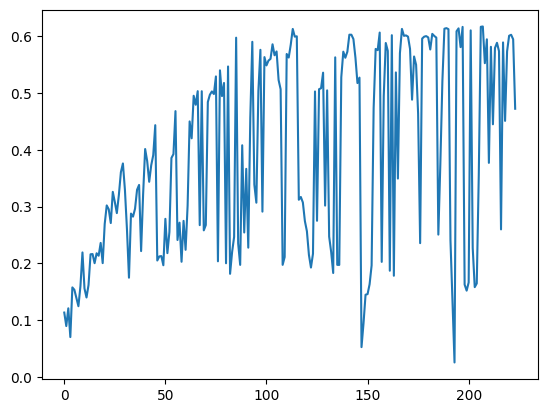

[PPO] Epoch 0: Loss=74.8121, Policy=0.0092, Value=149.6442
[PPO] Epoch 10: Loss=36.8059, Policy=0.0062, Value=73.6294
[PPO] Epoch 20: Loss=28.0208, Policy=-0.0163, Value=56.1092
[PPO] Epoch 30: Loss=17.9343, Policy=-0.0284, Value=35.9612
Approx KL Learned: 0.048322807997465134
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 57/100 — steps: 4096


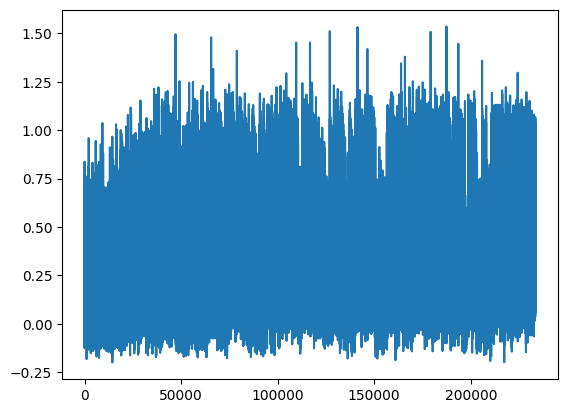

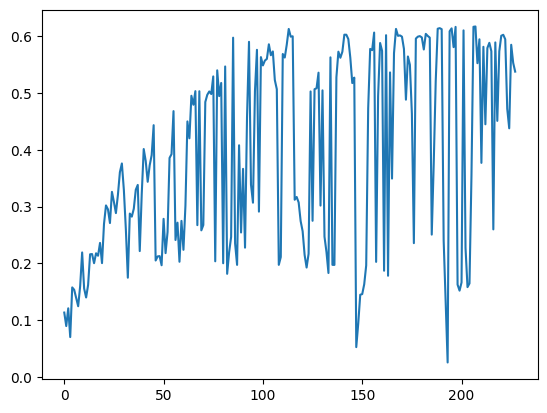

[PPO] Epoch 0: Loss=30.0730, Policy=0.0036, Value=60.1653
[PPO] Epoch 10: Loss=9.3493, Policy=0.0017, Value=18.7195
[PPO] Epoch 20: Loss=9.6014, Policy=-0.0056, Value=19.2385
[PPO] Epoch 30: Loss=6.8450, Policy=0.0137, Value=13.6972
Approx KL Learned: 0.26402002573013306
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 58/100 — steps: 4096


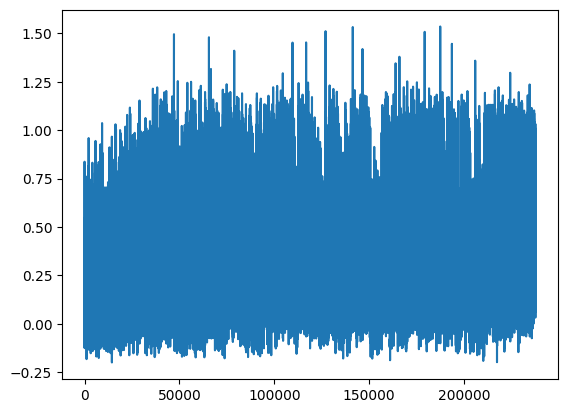

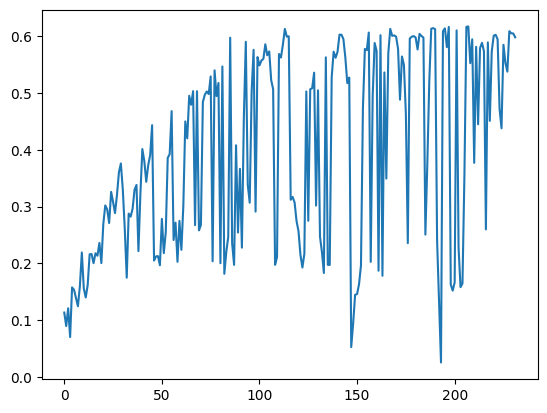

[PPO] Epoch 0: Loss=159.7765, Policy=0.0114, Value=319.5460
[PPO] Epoch 10: Loss=70.2256, Policy=0.0105, Value=140.4498
[PPO] Epoch 20: Loss=52.1049, Policy=0.0121, Value=104.2118
[PPO] Epoch 30: Loss=36.6536, Policy=-0.0075, Value=73.3649
Approx KL Learned: 0.1654420644044876
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 59/100 — steps: 4096


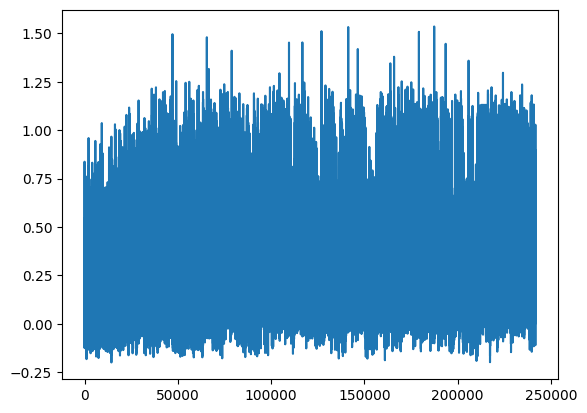

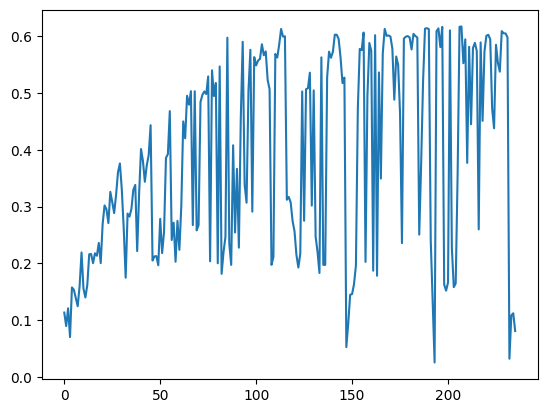

[PPO] Epoch 0: Loss=101.0487, Policy=0.0125, Value=202.1103
[PPO] Epoch 10: Loss=51.9460, Policy=0.0085, Value=103.9225
[PPO] Epoch 20: Loss=32.8091, Policy=-0.0003, Value=65.6675
[PPO] Epoch 30: Loss=21.8846, Policy=-0.0055, Value=43.8329
Approx KL Learned: 0.05984252691268921
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 60/100 — steps: 4096


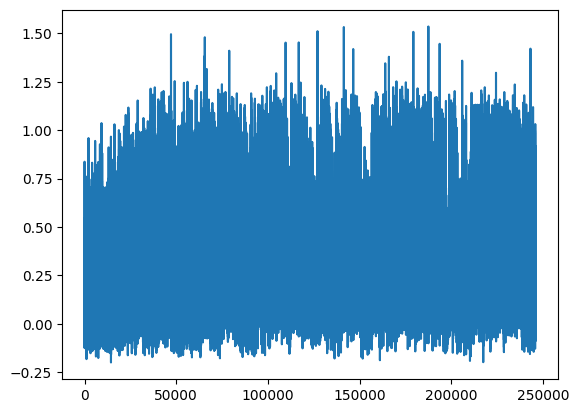

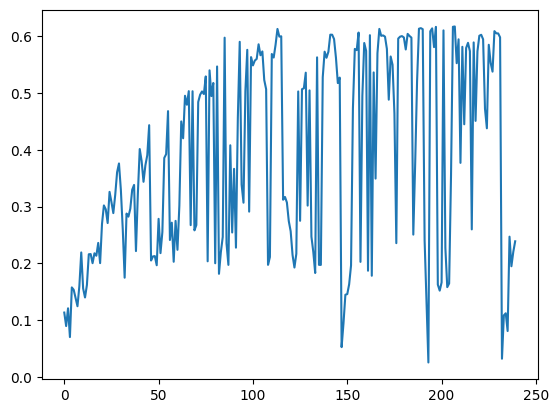

[PPO] Epoch 0: Loss=68.9927, Policy=0.0065, Value=138.0228
[PPO] Epoch 10: Loss=39.0504, Policy=0.0038, Value=78.1495
[PPO] Epoch 20: Loss=24.7948, Policy=-0.0071, Value=49.6605
[PPO] Epoch 30: Loss=19.9030, Policy=-0.0112, Value=39.8825
Approx KL Learned: 0.02702745608985424
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 61/100 — steps: 4096


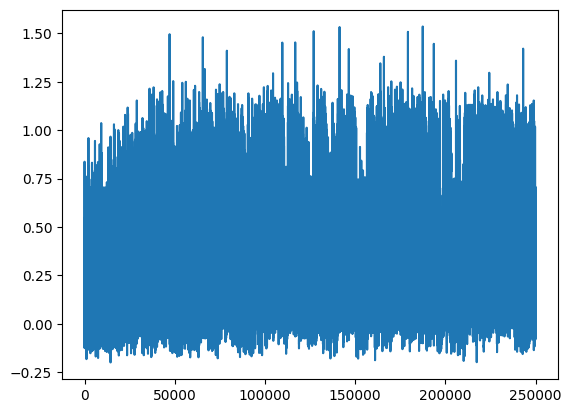

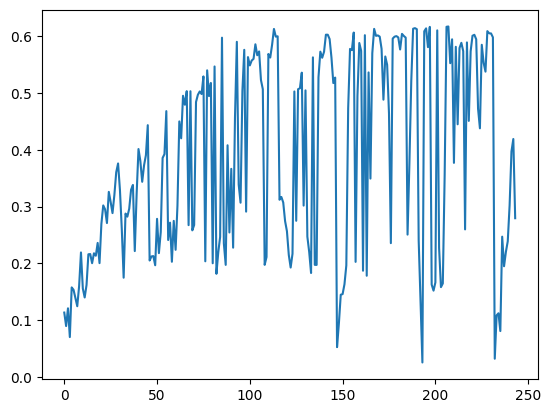

[PPO] Epoch 0: Loss=70.5412, Policy=0.0046, Value=141.1276
[PPO] Epoch 10: Loss=37.2393, Policy=-0.0016, Value=74.5387
[PPO] Epoch 20: Loss=19.1779, Policy=-0.0084, Value=38.4297
[PPO] Epoch 30: Loss=14.6083, Policy=-0.0159, Value=29.3048
Approx KL Learned: 0.03503530099987984
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 62/100 — steps: 4096


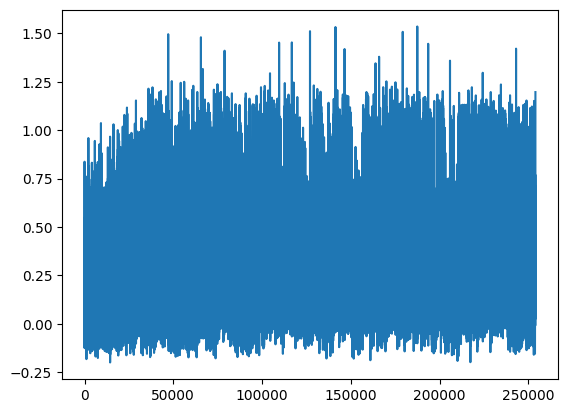

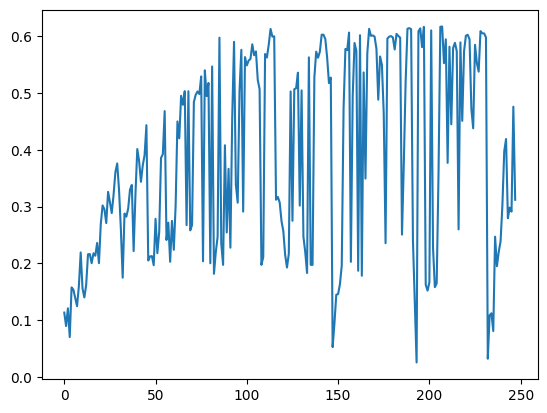

[PPO] Epoch 0: Loss=55.0505, Policy=0.0069, Value=110.1340
[PPO] Epoch 10: Loss=31.4154, Policy=-0.0040, Value=62.8847
[PPO] Epoch 20: Loss=19.1621, Policy=-0.0106, Value=38.3903
[PPO] Epoch 30: Loss=13.3982, Policy=-0.0130, Value=26.8673
Approx KL Learned: 0.021710850298404694
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 63/100 — steps: 4096


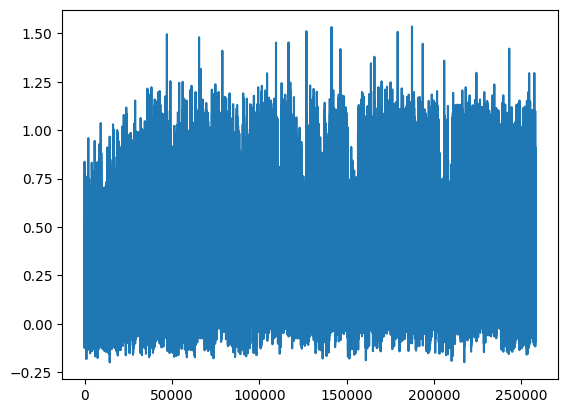

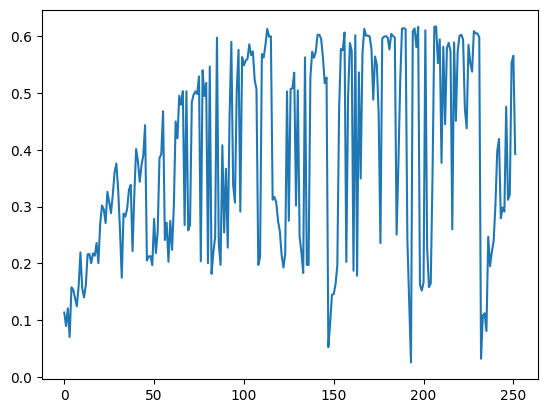

[PPO] Epoch 0: Loss=75.3373, Policy=0.0044, Value=150.7202
[PPO] Epoch 10: Loss=47.9216, Policy=-0.0003, Value=95.8987
[PPO] Epoch 20: Loss=31.3292, Policy=-0.0044, Value=62.7224
[PPO] Epoch 30: Loss=22.4208, Policy=-0.0128, Value=44.9235
Approx KL Learned: 0.02578829601407051
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 64/100 — steps: 4096


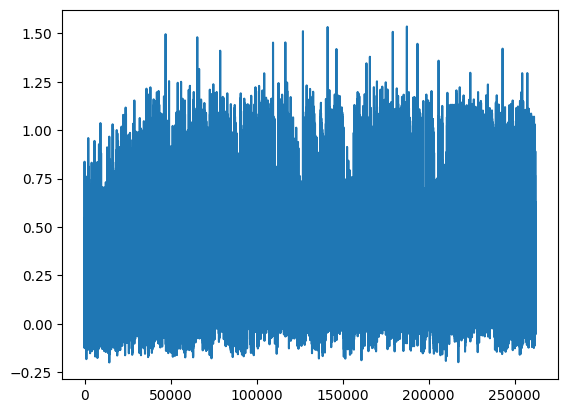

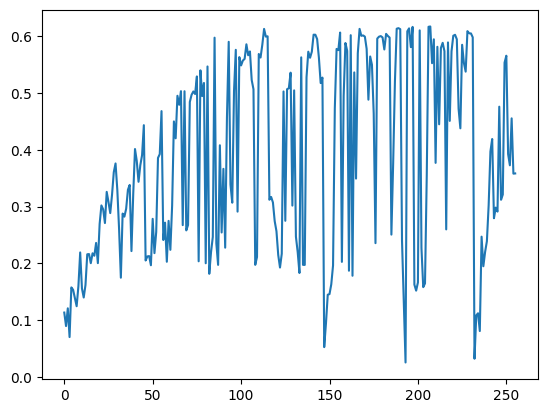

[PPO] Epoch 0: Loss=61.6141, Policy=0.0027, Value=123.2850
[PPO] Epoch 10: Loss=47.5926, Policy=-0.0011, Value=95.2495
[PPO] Epoch 20: Loss=29.1448, Policy=-0.0080, Value=58.3665
[PPO] Epoch 30: Loss=17.4011, Policy=0.0213, Value=34.8305
Approx KL Learned: 0.21344584226608276
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 65/100 — steps: 4096


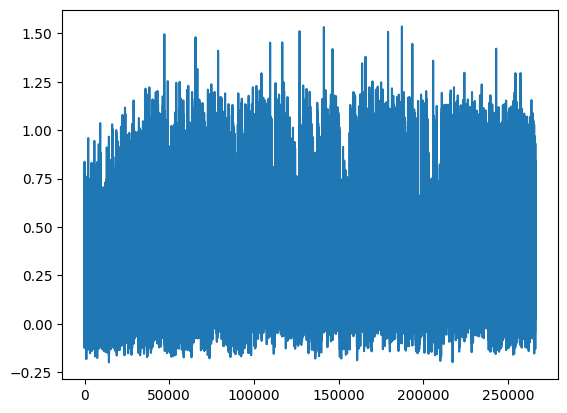

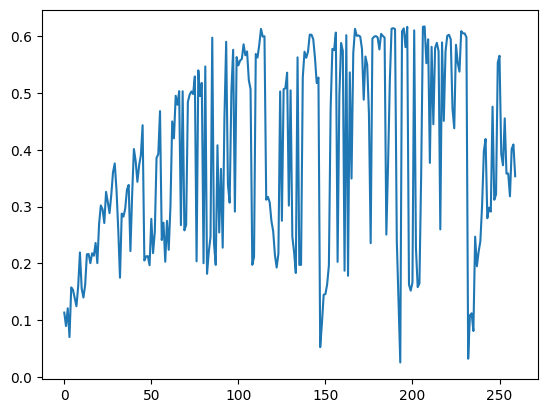

[PPO] Epoch 0: Loss=72.0060, Policy=0.0097, Value=144.0235
[PPO] Epoch 10: Loss=30.4691, Policy=0.0245, Value=60.9355
[PPO] Epoch 20: Loss=18.9464, Policy=0.0088, Value=37.9076
[PPO] Epoch 30: Loss=11.9920, Policy=-0.0050, Value=24.0270
Approx KL Learned: 0.018613159656524658
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 66/100 — steps: 4096


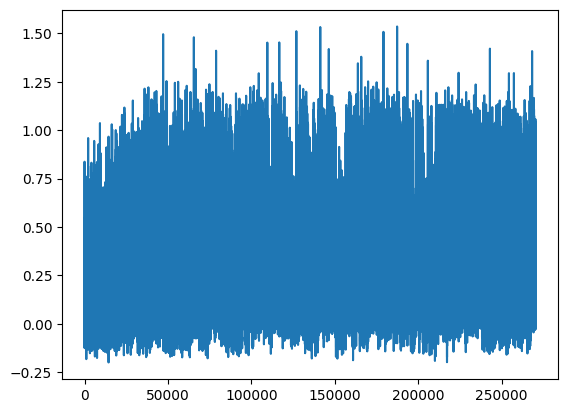

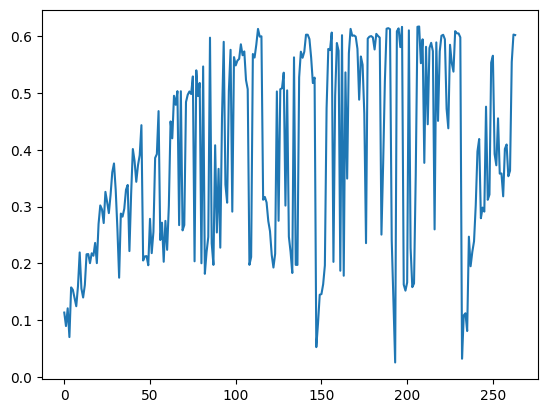

[PPO] Epoch 0: Loss=79.9587, Policy=0.0039, Value=159.9588
[PPO] Epoch 10: Loss=52.3903, Policy=0.0008, Value=104.8297
[PPO] Epoch 20: Loss=34.8864, Policy=-0.0073, Value=69.8372
[PPO] Epoch 30: Loss=24.1188, Policy=-0.0095, Value=48.3066
Approx KL Learned: 0.02025243081152439
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 67/100 — steps: 4096


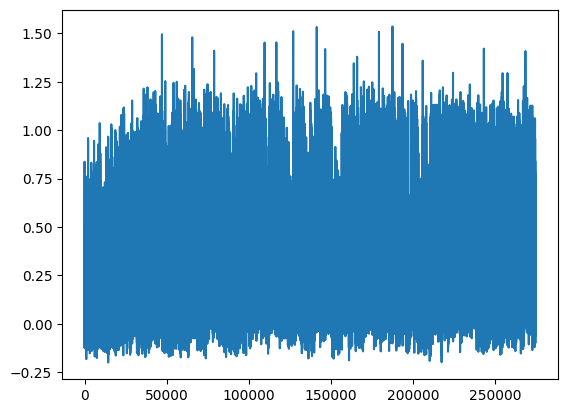

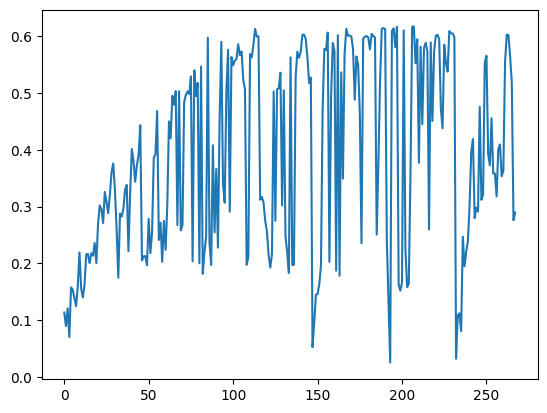

[PPO] Epoch 0: Loss=93.6706, Policy=0.0039, Value=187.4000
[PPO] Epoch 10: Loss=56.4829, Policy=0.0020, Value=113.0318
[PPO] Epoch 20: Loss=36.5495, Policy=-0.0085, Value=73.1848
[PPO] Epoch 30: Loss=21.6293, Policy=-0.0171, Value=43.3632
Approx KL Learned: 0.029682978987693787
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 68/100 — steps: 4096


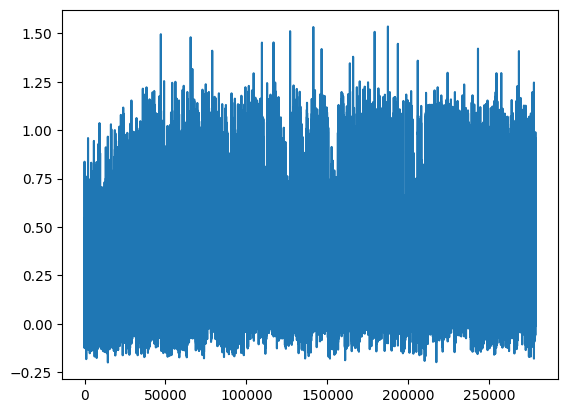

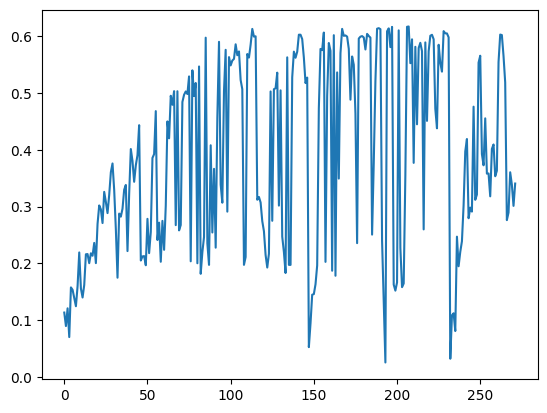

[PPO] Epoch 0: Loss=58.5462, Policy=0.0056, Value=117.1245
[PPO] Epoch 10: Loss=34.2979, Policy=-0.0007, Value=68.6414
[PPO] Epoch 20: Loss=21.1104, Policy=-0.0080, Value=42.2813
[PPO] Epoch 30: Loss=13.4043, Policy=-0.0158, Value=26.8849
Approx KL Learned: 0.02247675508260727
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 69/100 — steps: 4096


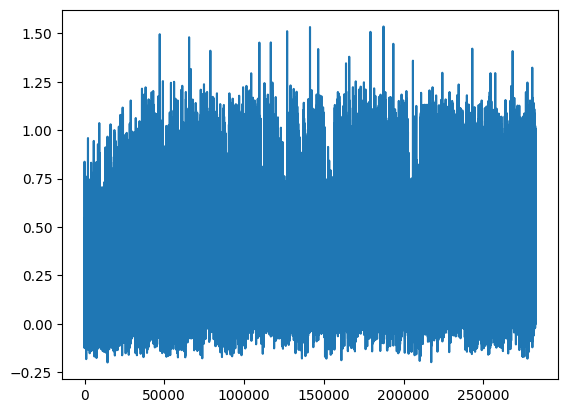

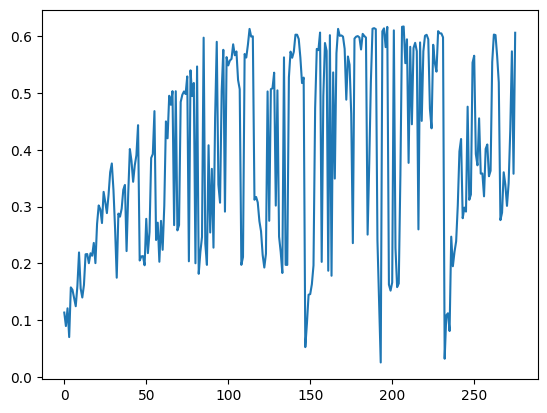

[PPO] Epoch 0: Loss=47.4197, Policy=0.0032, Value=94.8712
[PPO] Epoch 10: Loss=27.8556, Policy=-0.0046, Value=55.7561
[PPO] Epoch 20: Loss=17.3212, Policy=-0.0114, Value=34.7029
[PPO] Epoch 30: Loss=12.4882, Policy=-0.0212, Value=25.0559
Approx KL Learned: 0.035066887736320496
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 70/100 — steps: 4096


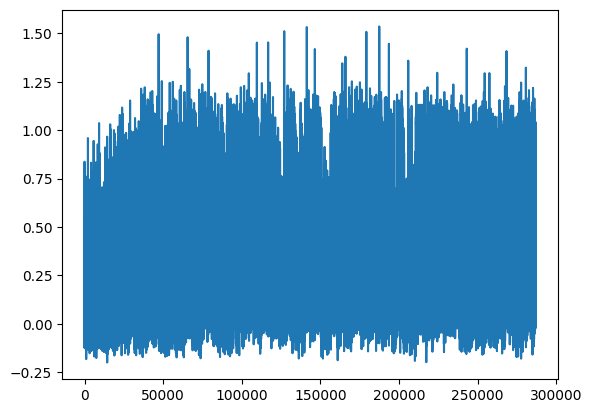

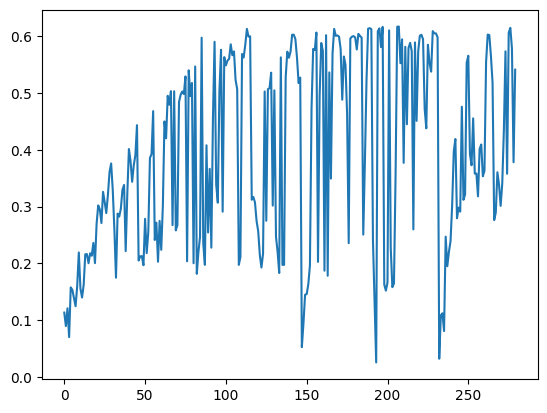

[PPO] Epoch 0: Loss=31.6904, Policy=0.0037, Value=63.4135
[PPO] Epoch 10: Loss=16.3139, Policy=-0.0015, Value=32.6725
[PPO] Epoch 20: Loss=10.4810, Policy=-0.0142, Value=21.0322
[PPO] Epoch 30: Loss=8.2720, Policy=-0.0265, Value=16.6384
Approx KL Learned: 0.0329497866332531
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 71/100 — steps: 4096


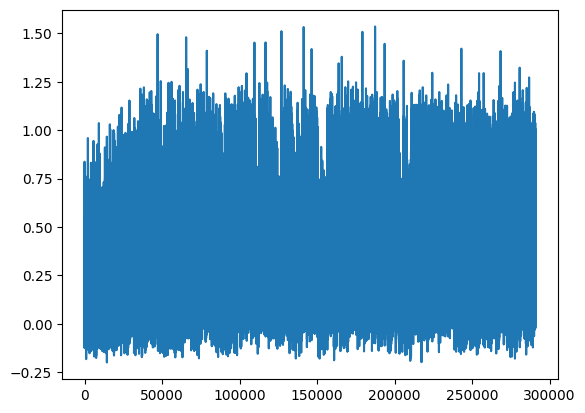

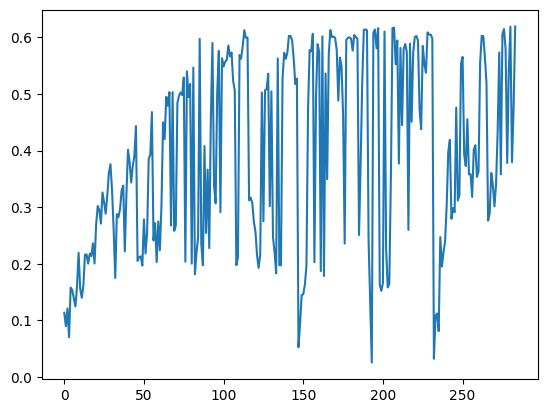

[PPO] Epoch 0: Loss=45.7819, Policy=-0.0015, Value=91.5871
[PPO] Epoch 10: Loss=13.9834, Policy=-0.0026, Value=27.9928
[PPO] Epoch 20: Loss=9.4096, Policy=-0.0098, Value=18.8613
[PPO] Epoch 30: Loss=6.9146, Policy=-0.0138, Value=13.8805
Approx KL Learned: 0.04436471313238144
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 72/100 — steps: 4096


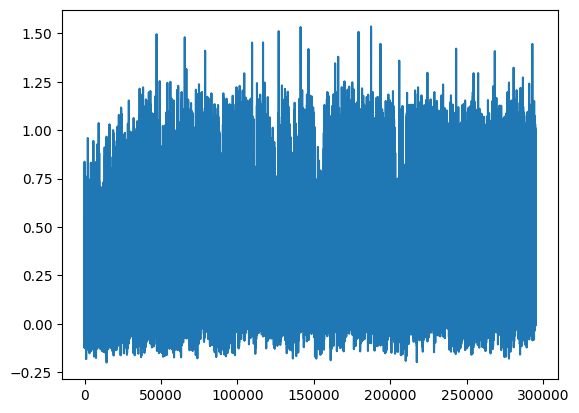

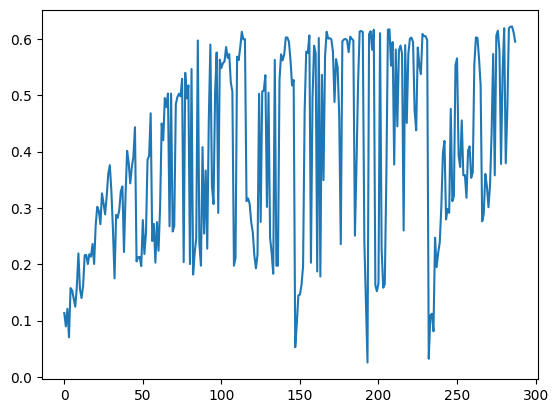

[PPO] Epoch 0: Loss=92.2905, Policy=0.0072, Value=184.6381
[PPO] Epoch 10: Loss=44.7101, Policy=0.0037, Value=89.4830
[PPO] Epoch 20: Loss=26.6230, Policy=-0.0156, Value=53.3469
[PPO] Epoch 30: Loss=17.6373, Policy=-0.0312, Value=35.4068
Approx KL Learned: 0.06030068174004555
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 73/100 — steps: 4096


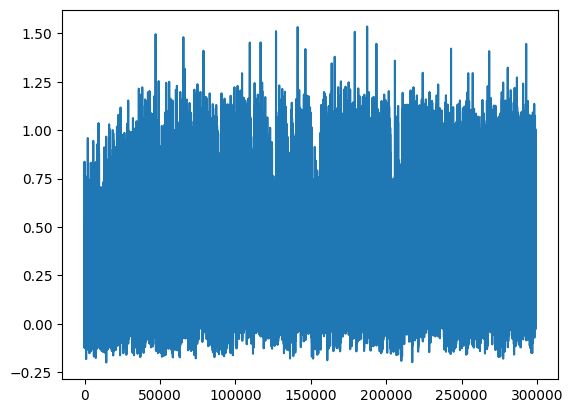

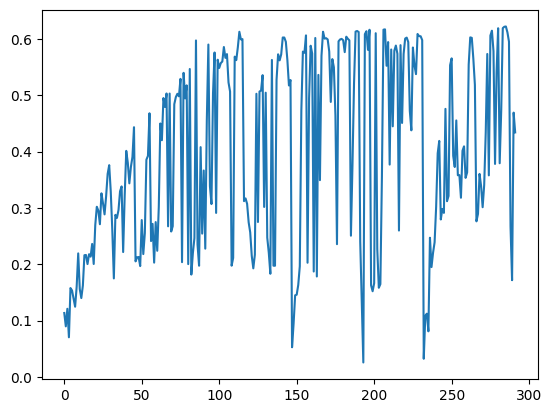

[PPO] Epoch 0: Loss=45.7083, Policy=0.0049, Value=91.4498
[PPO] Epoch 10: Loss=25.9617, Policy=-0.0009, Value=51.9670
[PPO] Epoch 20: Loss=17.3099, Policy=-0.0148, Value=34.6920
[PPO] Epoch 30: Loss=12.3219, Policy=-0.0262, Value=24.7393
Approx KL Learned: 0.03138601779937744
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 74/100 — steps: 4096


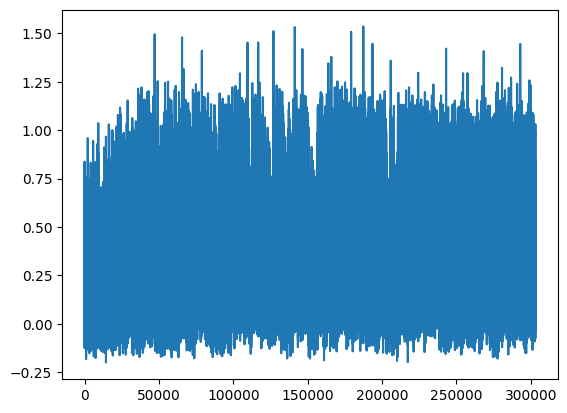

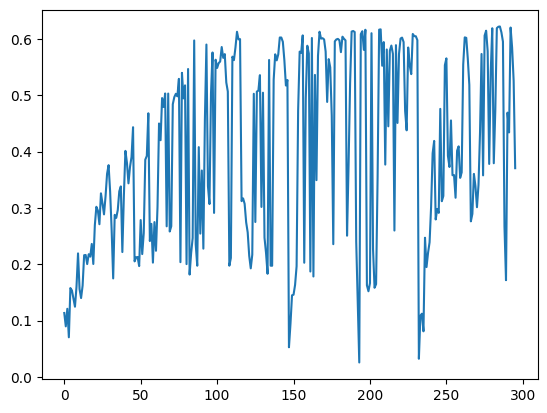

[PPO] Epoch 0: Loss=52.4250, Policy=0.0024, Value=104.8665
[PPO] Epoch 10: Loss=12.0016, Policy=-0.0015, Value=24.0263
[PPO] Epoch 20: Loss=8.8880, Policy=-0.0094, Value=17.8183
[PPO] Epoch 30: Loss=8.0870, Policy=-0.0156, Value=16.2289
Approx KL Learned: 0.09199516475200653
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 75/100 — steps: 4096


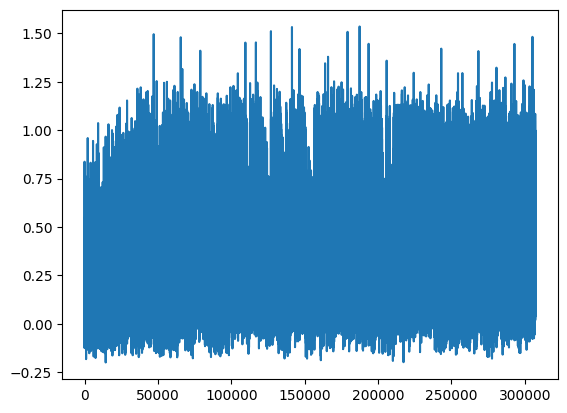

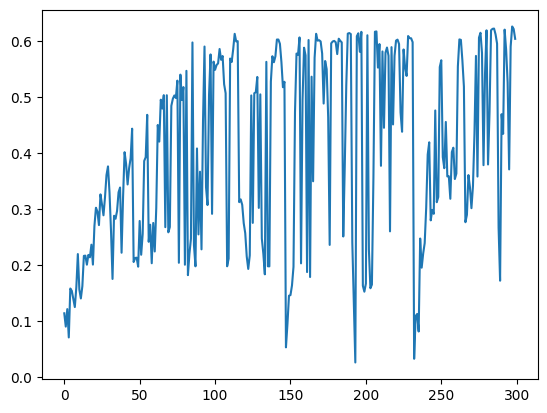

[PPO] Epoch 0: Loss=52.3820, Policy=0.0085, Value=104.7990
[PPO] Epoch 10: Loss=37.6802, Policy=0.0000, Value=75.4056
[PPO] Epoch 20: Loss=25.9749, Policy=-0.0115, Value=52.0215
[PPO] Epoch 30: Loss=17.3572, Policy=-0.0266, Value=34.8157
Approx KL Learned: 0.046970024704933167
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 76/100 — steps: 4096


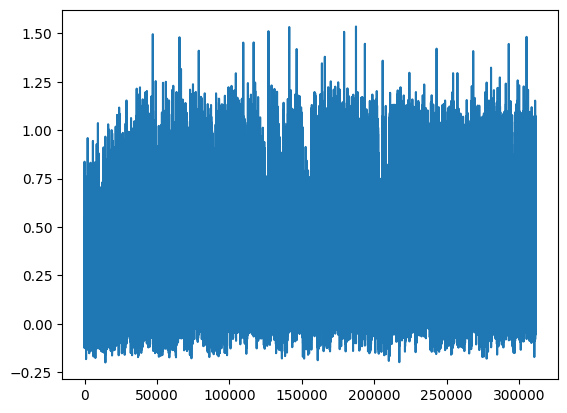

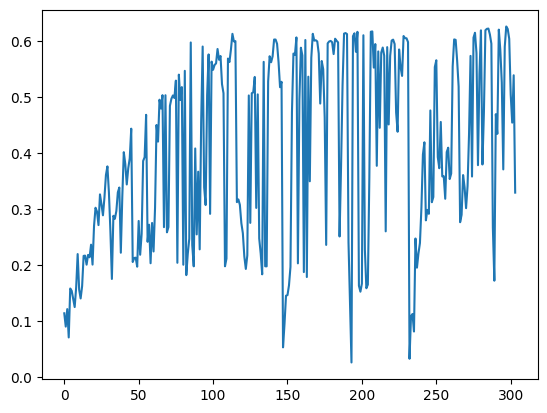

[PPO] Epoch 0: Loss=49.0102, Policy=0.0067, Value=98.0510
[PPO] Epoch 10: Loss=30.1885, Policy=-0.0027, Value=60.4229
[PPO] Epoch 20: Loss=20.6619, Policy=-0.0117, Value=41.3882
[PPO] Epoch 30: Loss=15.4740, Policy=-0.0200, Value=31.0295
Approx KL Learned: 0.035315170884132385
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 77/100 — steps: 4096


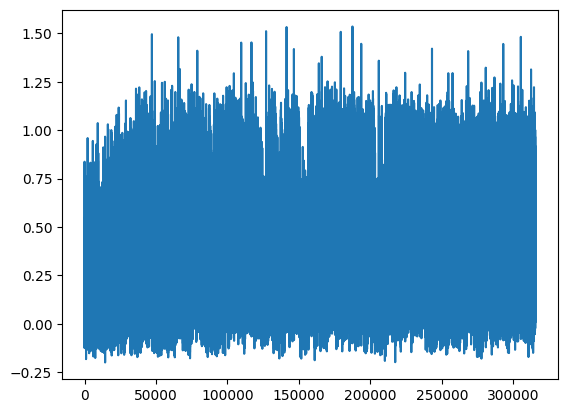

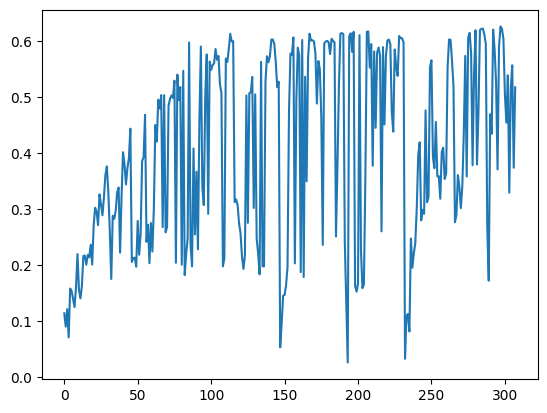

[PPO] Epoch 0: Loss=36.7512, Policy=0.0046, Value=73.5171
[PPO] Epoch 10: Loss=16.0696, Policy=-0.0059, Value=32.1732
[PPO] Epoch 20: Loss=12.3680, Policy=-0.0124, Value=24.7828
[PPO] Epoch 30: Loss=10.1038, Policy=-0.0167, Value=20.2643
Approx KL Learned: 0.036577023565769196
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 78/100 — steps: 4096


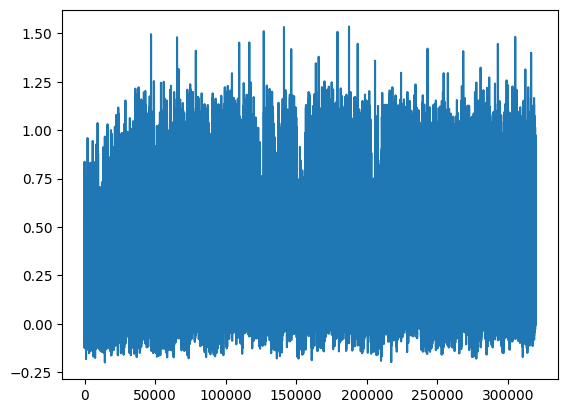

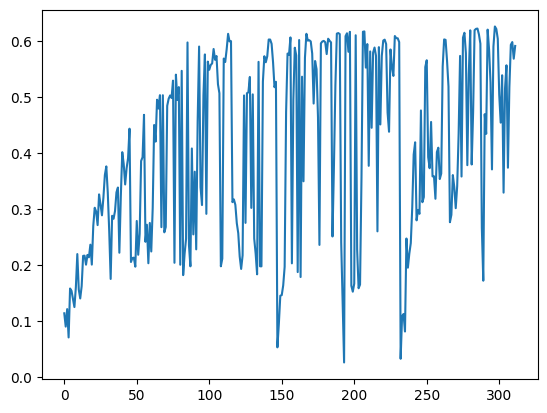

[PPO] Epoch 0: Loss=32.3161, Policy=0.0026, Value=64.6586
[PPO] Epoch 10: Loss=18.9761, Policy=-0.0075, Value=37.9992
[PPO] Epoch 20: Loss=13.2274, Policy=-0.0247, Value=26.5356
[PPO] Epoch 30: Loss=10.6774, Policy=-0.0244, Value=21.4338
Approx KL Learned: 0.048523783683776855
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 79/100 — steps: 4096


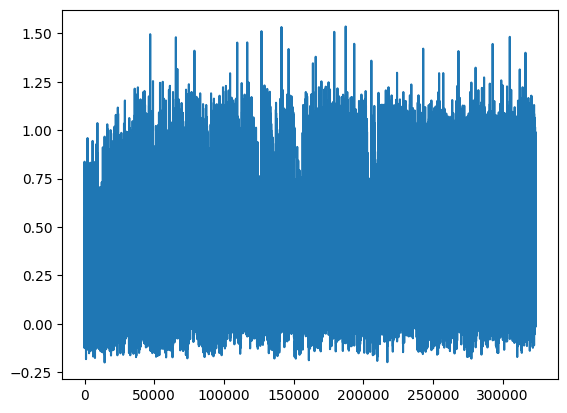

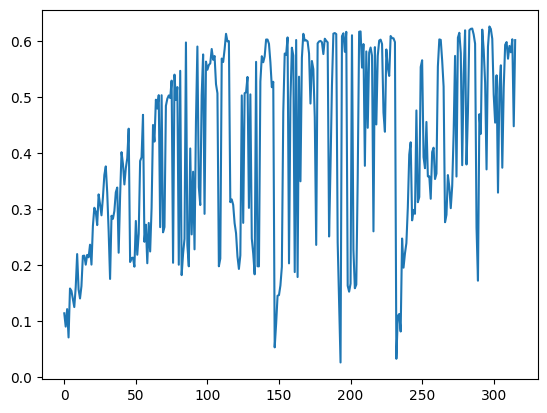

[PPO] Epoch 0: Loss=68.6863, Policy=0.0064, Value=137.4132
[PPO] Epoch 10: Loss=29.5294, Policy=-0.0020, Value=59.1169
[PPO] Epoch 20: Loss=17.5964, Policy=-0.0186, Value=35.2852
[PPO] Epoch 30: Loss=9.2768, Policy=-0.0326, Value=18.6715
Approx KL Learned: 0.04796002432703972
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 80/100 — steps: 4096


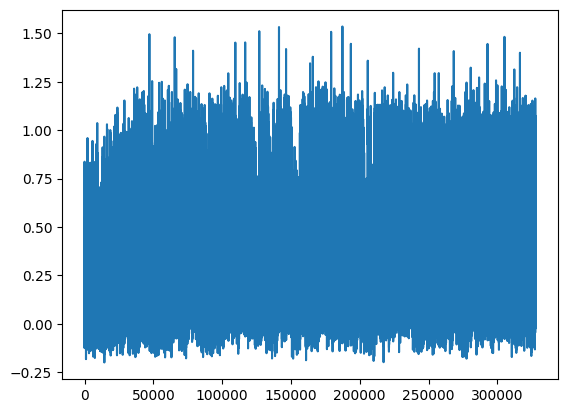

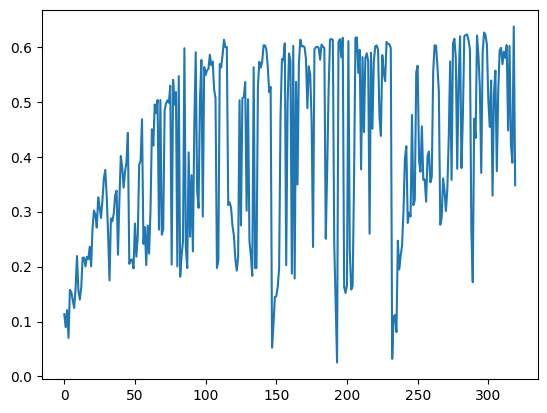

[PPO] Epoch 0: Loss=25.7220, Policy=0.0034, Value=51.4536
[PPO] Epoch 10: Loss=9.6445, Policy=0.0009, Value=19.3036
[PPO] Epoch 20: Loss=6.4918, Policy=-0.0088, Value=13.0197
[PPO] Epoch 30: Loss=4.9517, Policy=-0.0170, Value=9.9608
Approx KL Learned: 0.09476356953382492
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 81/100 — steps: 4096


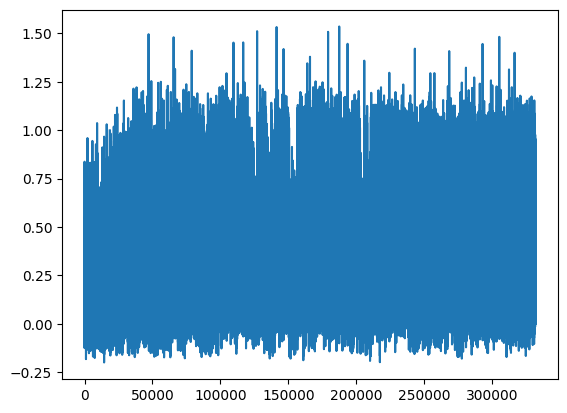

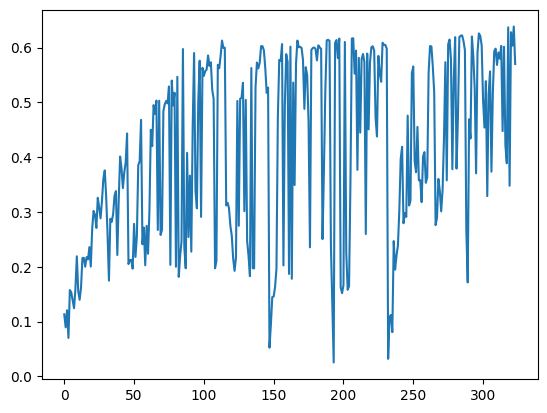

[PPO] Epoch 0: Loss=27.7799, Policy=0.0134, Value=55.5699
[PPO] Epoch 10: Loss=15.2004, Policy=-0.0008, Value=30.4375
[PPO] Epoch 20: Loss=12.0662, Policy=-0.0096, Value=24.1866
[PPO] Epoch 30: Loss=9.4543, Policy=-0.0051, Value=18.9568
Approx KL Learned: 0.18985320627689362
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 82/100 — steps: 4096


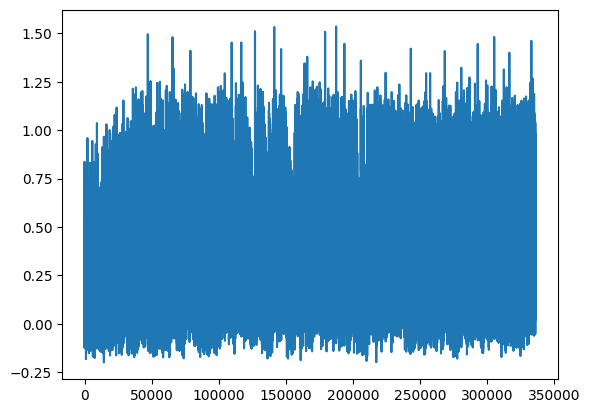

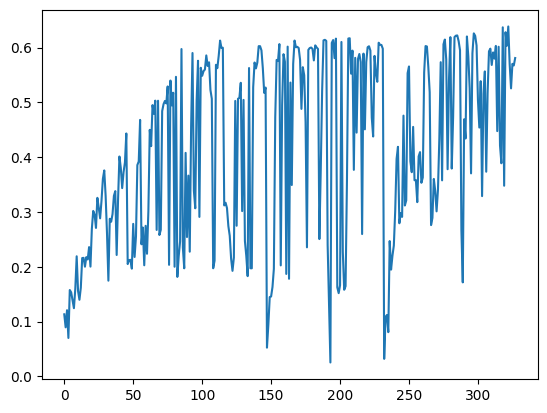

[PPO] Epoch 0: Loss=102.6406, Policy=0.0173, Value=205.3269
[PPO] Epoch 10: Loss=62.2933, Policy=0.0188, Value=124.6323
[PPO] Epoch 20: Loss=40.6236, Policy=0.0004, Value=81.3280
[PPO] Epoch 30: Loss=23.9709, Policy=-0.0115, Value=48.0477
Approx KL Learned: 0.04802563041448593
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 83/100 — steps: 4096


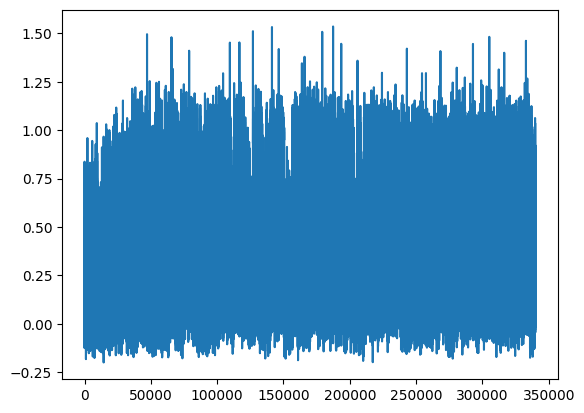

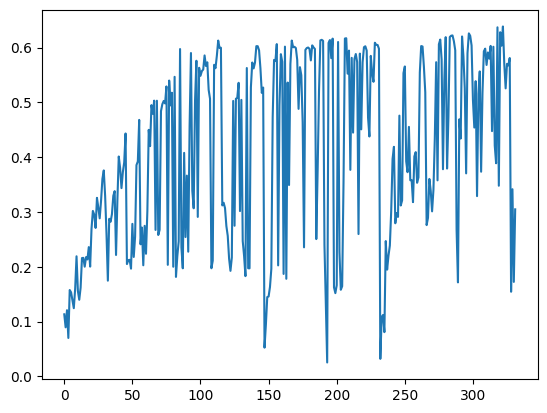

[PPO] Epoch 0: Loss=81.9418, Policy=0.0124, Value=163.9150
[PPO] Epoch 10: Loss=50.0495, Policy=-0.0033, Value=100.1596
[PPO] Epoch 20: Loss=34.6519, Policy=-0.0139, Value=69.3891
[PPO] Epoch 30: Loss=26.8875, Policy=-0.0208, Value=53.8758
Approx KL Learned: 0.05219223350286484
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 84/100 — steps: 4096


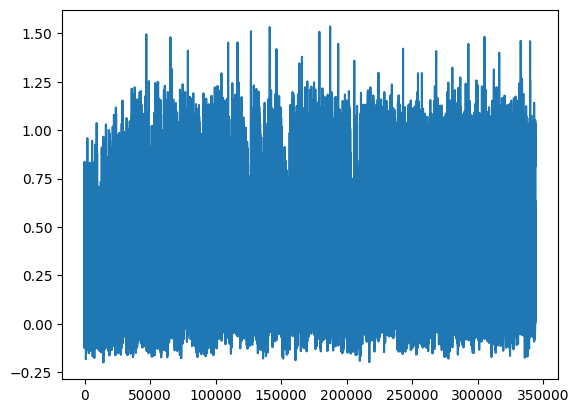

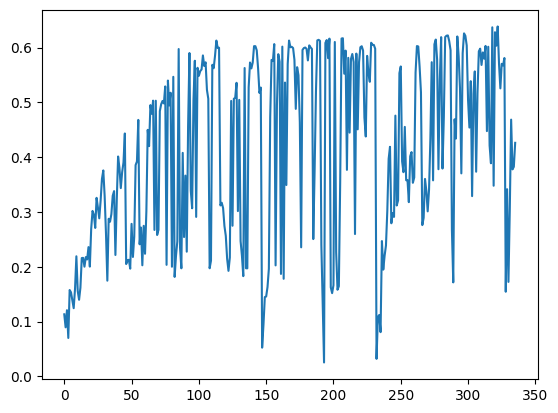

[PPO] Epoch 0: Loss=94.1455, Policy=0.0046, Value=188.3563
[PPO] Epoch 10: Loss=59.7578, Policy=-0.0021, Value=119.5930
[PPO] Epoch 20: Loss=35.0208, Policy=-0.0098, Value=70.1348
[PPO] Epoch 30: Loss=22.6268, Policy=-0.0181, Value=45.3635
Approx KL Learned: 0.04568573832511902
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 85/100 — steps: 4096


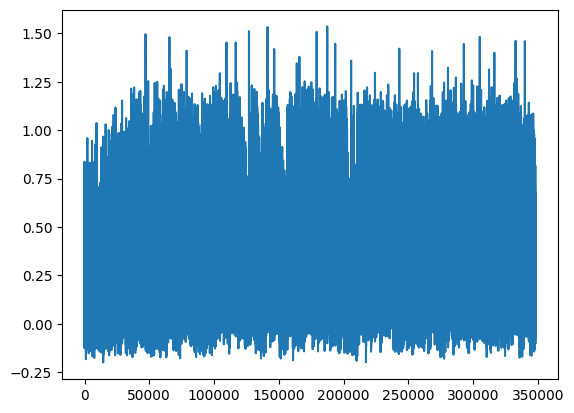

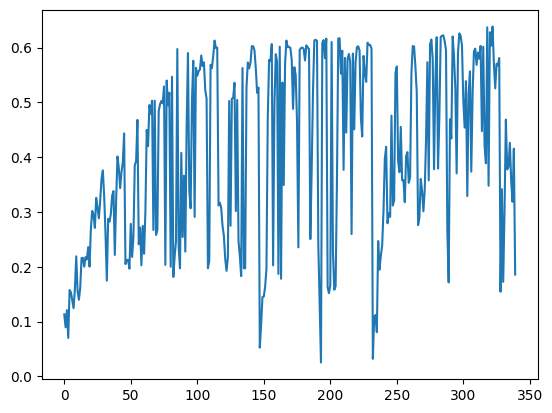

[PPO] Epoch 0: Loss=73.1549, Policy=0.0062, Value=146.3564
[PPO] Epoch 10: Loss=43.5669, Policy=0.0002, Value=87.1899
[PPO] Epoch 20: Loss=28.5839, Policy=-0.0085, Value=57.2413
[PPO] Epoch 30: Loss=20.3177, Policy=-0.0143, Value=40.7208
Approx KL Learned: 0.03572293370962143
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 86/100 — steps: 4096


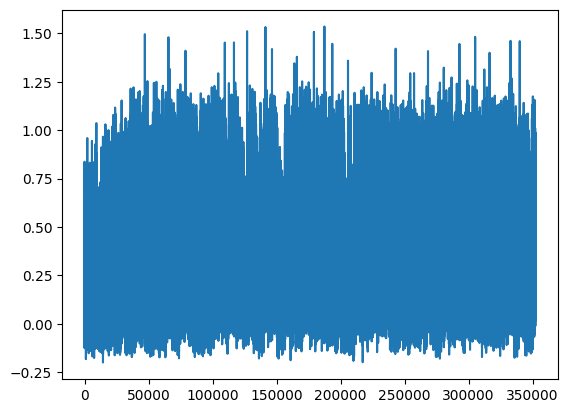

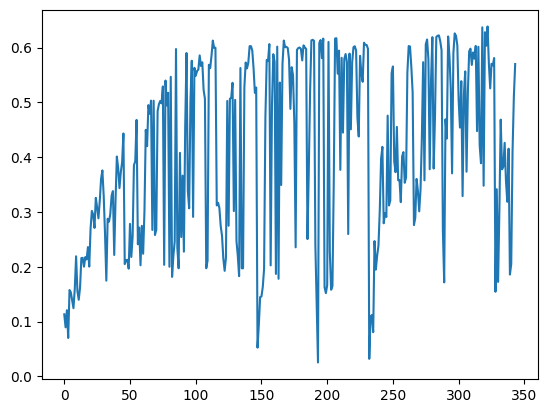

[PPO] Epoch 0: Loss=97.6313, Policy=0.0074, Value=195.2868
[PPO] Epoch 10: Loss=49.4730, Policy=0.0027, Value=98.9769
[PPO] Epoch 20: Loss=38.0089, Policy=-0.0009, Value=76.0562
[PPO] Epoch 30: Loss=33.7735, Policy=-0.0093, Value=67.6027
Approx KL Learned: 0.026896189898252487
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 87/100 — steps: 4096


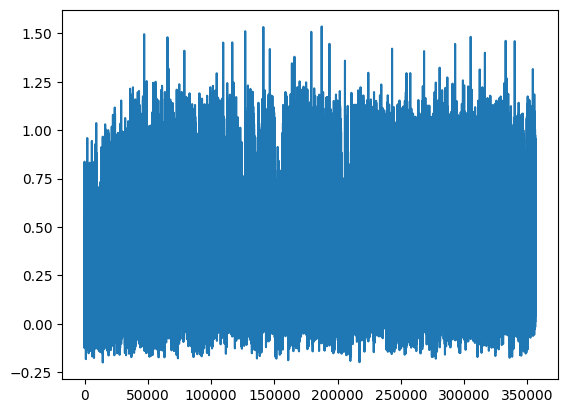

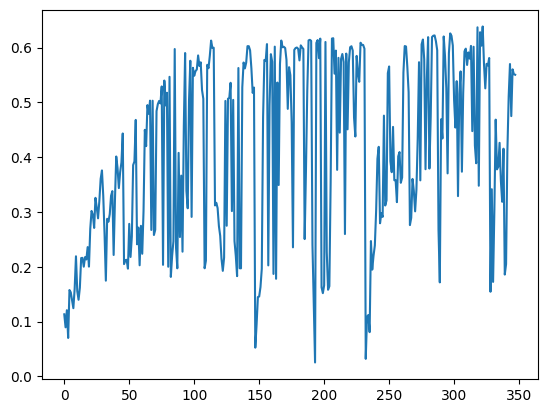

[PPO] Epoch 0: Loss=52.0831, Policy=0.0107, Value=104.1826
[PPO] Epoch 10: Loss=29.1416, Policy=-0.0008, Value=58.3188
[PPO] Epoch 20: Loss=21.6432, Policy=-0.0094, Value=43.3396
[PPO] Epoch 30: Loss=15.4876, Policy=-0.0135, Value=31.0409
Approx KL Learned: 0.027418717741966248
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 88/100 — steps: 4096


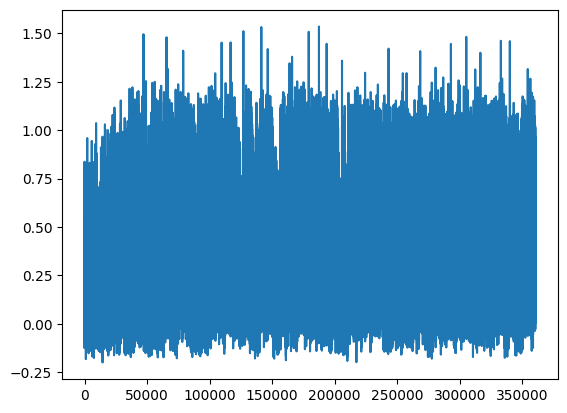

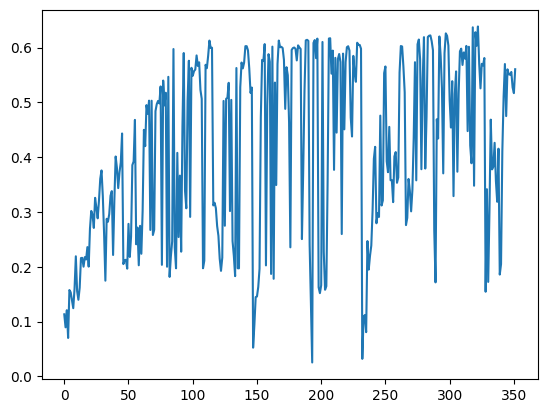

[PPO] Epoch 0: Loss=56.4757, Policy=0.0052, Value=112.9772
[PPO] Epoch 10: Loss=27.2995, Policy=0.0003, Value=54.6321
[PPO] Epoch 20: Loss=18.2726, Policy=-0.0059, Value=36.5925
[PPO] Epoch 30: Loss=12.4391, Policy=-0.0177, Value=24.9512
Approx KL Learned: 0.038836315274238586
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 89/100 — steps: 4096


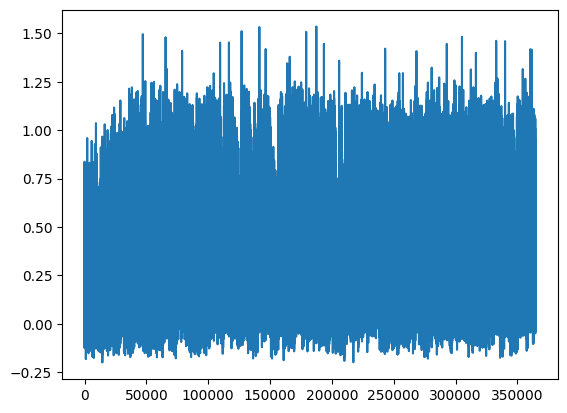

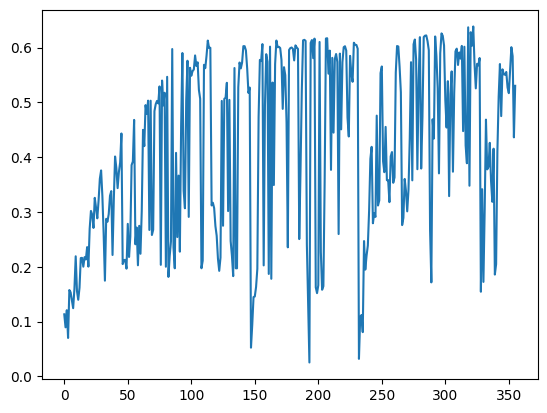

[PPO] Epoch 0: Loss=27.1659, Policy=0.0081, Value=54.3462
[PPO] Epoch 10: Loss=13.3548, Policy=-0.0091, Value=26.7527
[PPO] Epoch 20: Loss=9.5215, Policy=-0.0152, Value=19.1008
[PPO] Epoch 30: Loss=7.5786, Policy=-0.0125, Value=15.2133
Approx KL Learned: 0.041782066226005554
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 90/100 — steps: 4096


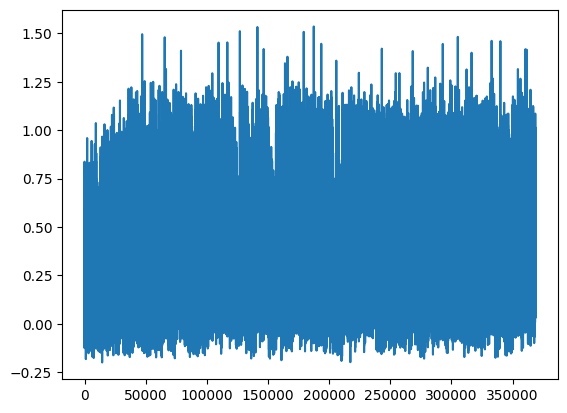

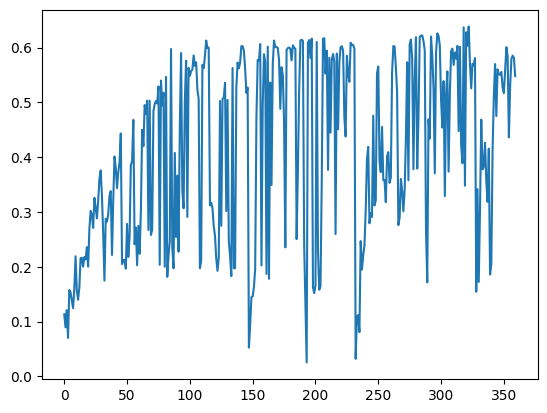

[PPO] Epoch 0: Loss=22.4251, Policy=0.0039, Value=44.8635
[PPO] Epoch 10: Loss=12.0329, Policy=-0.0025, Value=24.0888
[PPO] Epoch 20: Loss=9.2296, Policy=-0.0076, Value=18.4927
[PPO] Epoch 30: Loss=7.7550, Policy=-0.0093, Value=15.5503
Approx KL Learned: 0.019293539226055145
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 91/100 — steps: 4096


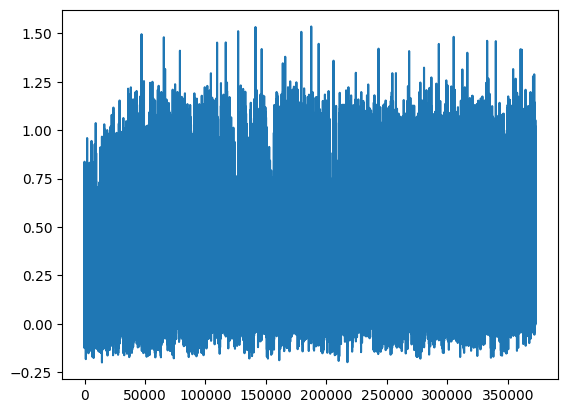

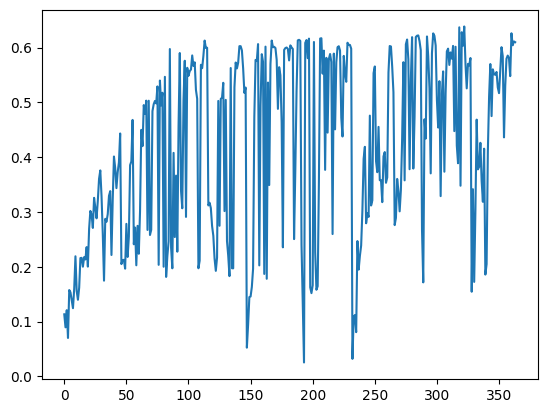

[PPO] Epoch 0: Loss=109.6185, Policy=0.0101, Value=219.2780
[PPO] Epoch 10: Loss=31.1687, Policy=0.0078, Value=62.3821
[PPO] Epoch 20: Loss=19.9910, Policy=-0.0058, Value=40.0533
[PPO] Epoch 30: Loss=13.0719, Policy=-0.0138, Value=26.2314
Approx KL Learned: 0.04093709588050842
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 92/100 — steps: 4096


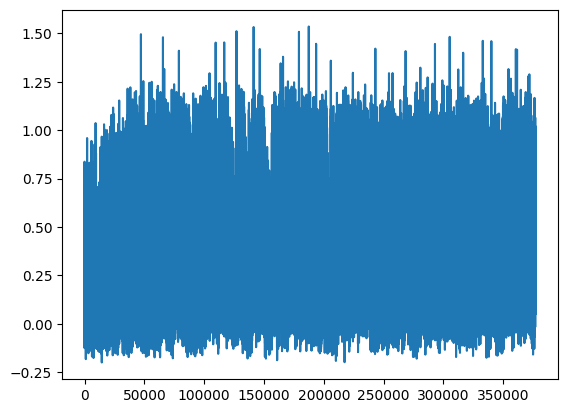

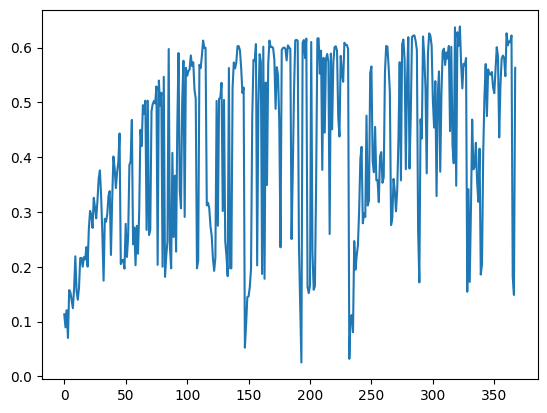

[PPO] Epoch 0: Loss=35.5578, Policy=0.0040, Value=71.1228
[PPO] Epoch 10: Loss=12.5709, Policy=-0.0005, Value=25.1575
[PPO] Epoch 20: Loss=7.7667, Policy=-0.0046, Value=15.5591
[PPO] Epoch 30: Loss=7.2291, Policy=-0.0131, Value=14.5027
Approx KL Learned: 0.08594228327274323
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 93/100 — steps: 4096


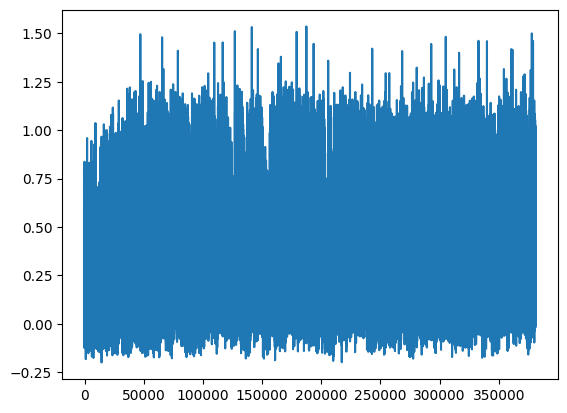

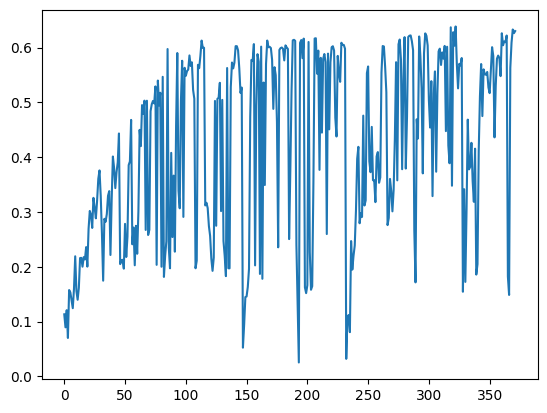

[PPO] Epoch 0: Loss=78.1448, Policy=0.0096, Value=156.3445
[PPO] Epoch 10: Loss=41.2124, Policy=0.0037, Value=82.4902
[PPO] Epoch 20: Loss=27.6105, Policy=-0.0103, Value=55.3145
[PPO] Epoch 30: Loss=18.7258, Policy=-0.0177, Value=37.5590
Approx KL Learned: 0.05377638712525368
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 94/100 — steps: 4096


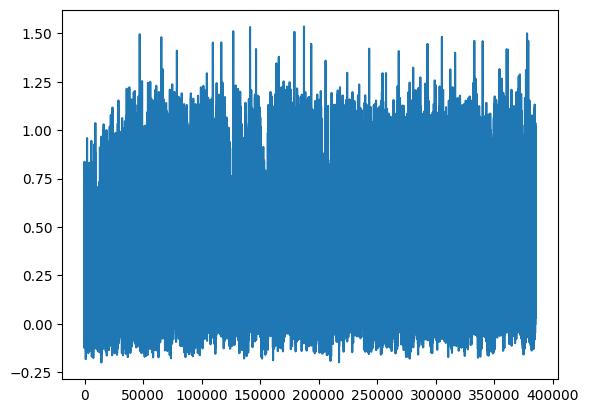

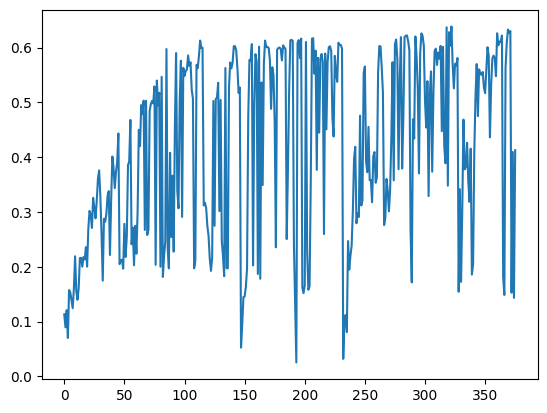

[PPO] Epoch 0: Loss=55.5605, Policy=0.0040, Value=111.1760
[PPO] Epoch 10: Loss=27.5924, Policy=-0.0025, Value=55.2517
[PPO] Epoch 20: Loss=19.5203, Policy=-0.0105, Value=39.1254
[PPO] Epoch 30: Loss=13.8926, Policy=-0.0250, Value=27.8988
Approx KL Learned: 0.05158740282058716
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 95/100 — steps: 4096


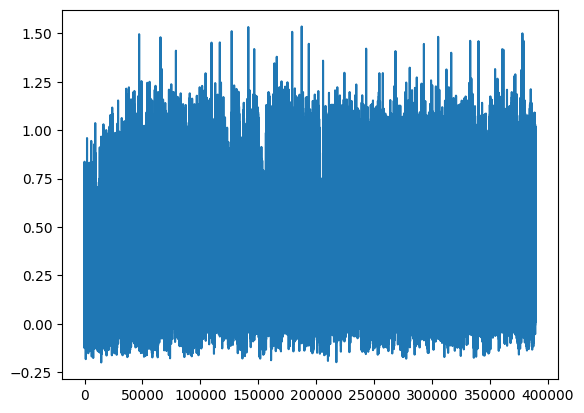

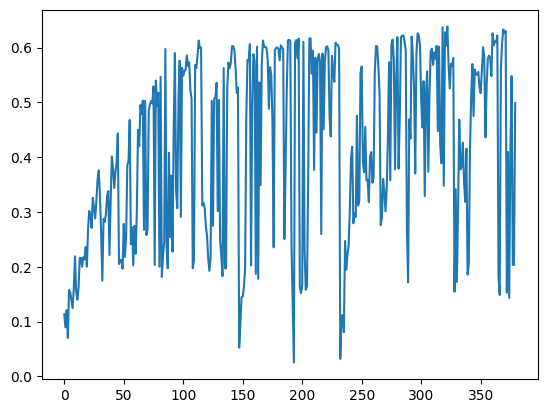

[PPO] Epoch 0: Loss=65.5950, Policy=0.0078, Value=131.2118
[PPO] Epoch 10: Loss=24.5680, Policy=0.0053, Value=49.1633
[PPO] Epoch 20: Loss=18.4186, Policy=-0.0103, Value=36.8961
[PPO] Epoch 30: Loss=13.3376, Policy=-0.0225, Value=26.7572
Approx KL Learned: 0.03331249952316284
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 96/100 — steps: 4096


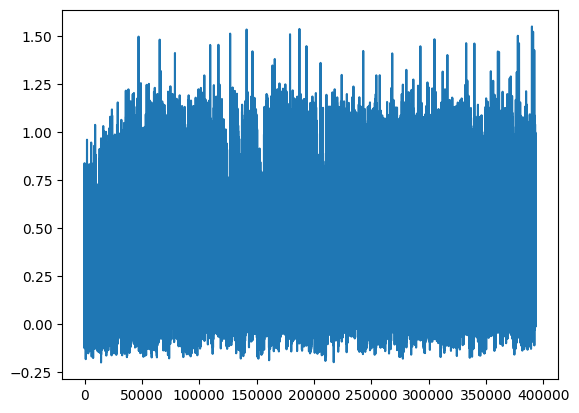

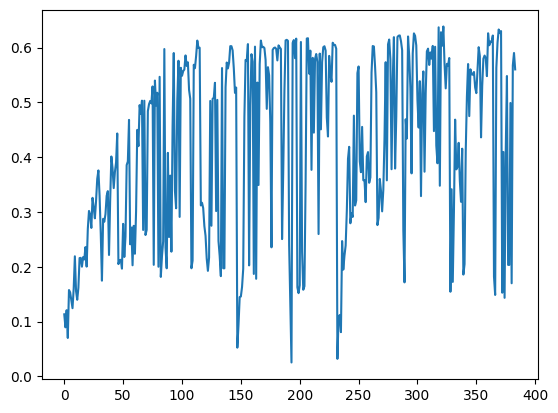

[PPO] Epoch 0: Loss=122.2321, Policy=0.0119, Value=244.5295
[PPO] Epoch 10: Loss=62.5007, Policy=0.0031, Value=125.0833
[PPO] Epoch 20: Loss=51.7899, Policy=-0.0050, Value=103.6779
[PPO] Epoch 30: Loss=39.6143, Policy=-0.0150, Value=79.3473
Approx KL Learned: 0.03169780969619751
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 97/100 — steps: 4096


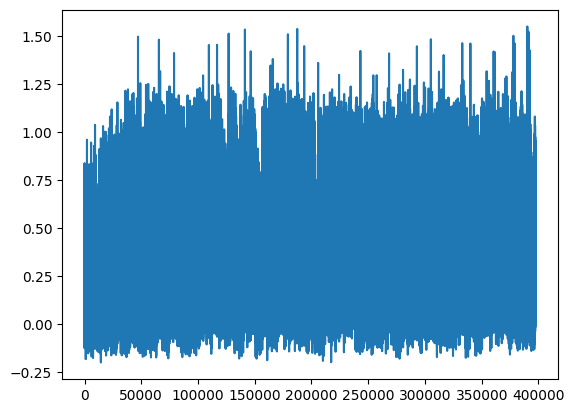

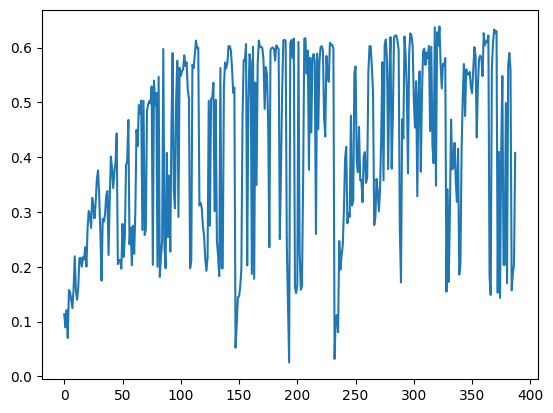

[PPO] Epoch 0: Loss=113.2658, Policy=0.0057, Value=226.5363
[PPO] Epoch 10: Loss=115.3889, Policy=-0.0004, Value=230.7933
[PPO] Epoch 20: Loss=14.8105, Policy=-0.0045, Value=29.6483
[PPO] Epoch 30: Loss=11.6051, Policy=-0.0185, Value=23.2759
Approx KL Learned: 0.16821840405464172
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 98/100 — steps: 4096


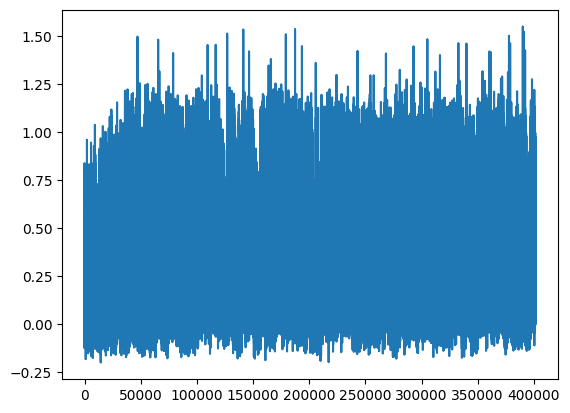

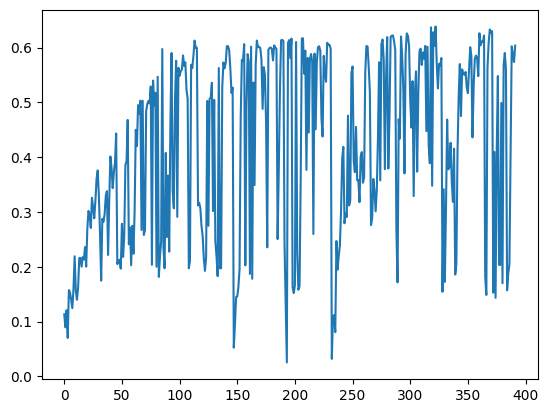

[PPO] Epoch 0: Loss=220.8277, Policy=0.0129, Value=441.7180
[PPO] Epoch 10: Loss=104.8571, Policy=0.0137, Value=209.7745
[PPO] Epoch 20: Loss=59.7889, Policy=0.0018, Value=119.6651
[PPO] Epoch 30: Loss=44.6228, Policy=-0.0074, Value=89.3522
Approx KL Learned: 0.022433221340179443
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 99/100 — steps: 4096


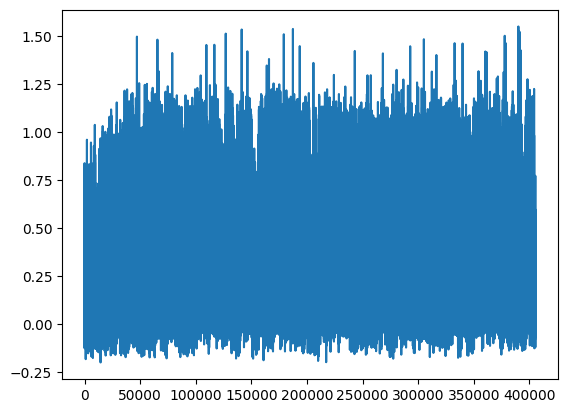

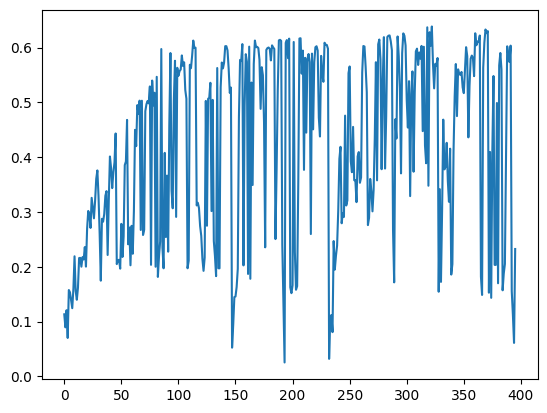

[PPO] Epoch 0: Loss=172.2132, Policy=0.0092, Value=344.4753
[PPO] Epoch 10: Loss=117.3040, Policy=-0.0007, Value=234.6779
[PPO] Epoch 20: Loss=95.6018, Policy=-0.0056, Value=191.2845
[PPO] Epoch 30: Loss=70.2275, Policy=-0.0109, Value=140.5483
Approx KL Learned: 0.04391197860240936
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 100/100 — steps: 4096


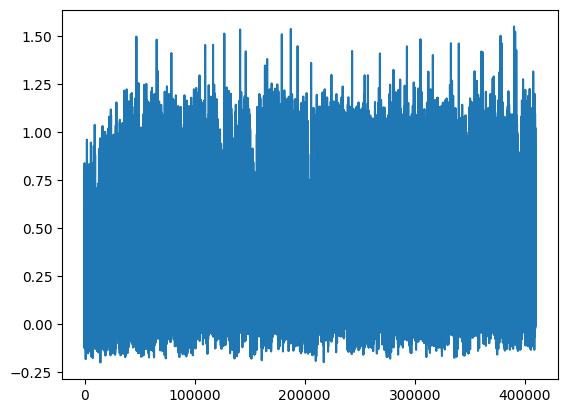

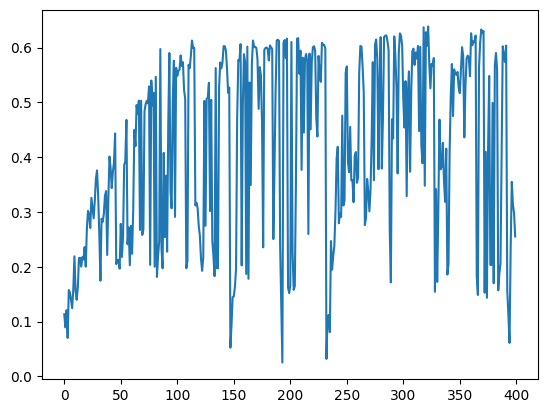

In [13]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 100)

In [249]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic, "data/new_env/clip_actor_critic_checkpoint_long_training_50.pt", device="cpu")

[🔁] Actor-Critic checkpoint loaded from data/new_env/clip_actor_critic_checkpoint_long_training_50.pt


In [ ]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio
import cv2
from rl import teleport

def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=512
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---------- Get raw frame (RGB) ----------
        frame = event.frame                     # H x W x 3, RGB uint8
        frame_bgr = frame[:, :, ::-1].copy()    # Convert to BGR for OpenCV

        # ---------- Determine arrow ----------
        # Compute the distribution BEFORE sampling
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

            if len(actions_seq) == 0:
                actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

            actions_tensor = torch.tensor(
                actions_seq, dtype=torch.long, device=DEVICE
            ).unsqueeze(0)

            dist = get_distribution(obs_seq, actions_tensor, actor_critic)

            probs = dist.probs.squeeze(0).cpu().numpy()
            argmax_action = int(np.argmax(probs))

        # Symbol selection
        if argmax_action == 0:
            symbol = "^"
        elif argmax_action == 1:
            symbol = ">"
        elif argmax_action == 2:
            symbol = "<"
        else:
            symbol = "?"

        symbol += " " + f"{float(np.max(probs) * 100):.1f}%"

        # ---------- Draw arrow with OpenCV ----------
        cv2.putText(
            frame_bgr,
            symbol,
            (30, 60),                # position (x, y)
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5,                     # font scale
            (0, 0, 255),             # color (BGR red)
            3,                       # thickness
            cv2.LINE_AA,
        )

        # ---------- Write to video (convert back to RGB) ----------
        writer.append_data(frame_bgr[:, :, ::-1])

        # ---------- Track positions ----------
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        # ---------- Sample next action ----------
        action_idx = dist.sample().item()

        event, reward = env.step_env(controller, action_idx)

        # ---------- Store enc + action ----------
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25]))
    print(dist.probs)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]

# init_pos = {'x': 7.609454154968262, 'y': 0.9009993672370911, 'z': 2.6405439376831055}
init_pos = {'x': 7.346313953399658, 'y': 0.9009993672370911, 'z': 2.8414998054504395}
for i in range(12):
    inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic, video_path=f"rollout_{i}.mp4")

{'x': 3.986215591430664, 'y': 0.9009993672370911, 'z': 3.9485578536987305}
tensor([0.9707, 0.0218, 0.0075])
tensor([0.9765, 0.0189, 0.0046])
tensor([0.9648, 0.0239, 0.0113])
tensor([0.8101, 0.1389, 0.0511])
tensor([0.9345, 0.0313, 0.0342])
tensor([0.9225, 0.0358, 0.0417])
tensor([0.6857, 0.1744, 0.1398])
tensor([0.7396, 0.1621, 0.0983])
tensor([0.5691, 0.1419, 0.2890])
tensor([0.2870, 0.3399, 0.3731])
tensor([0.2122, 0.1522, 0.6356])
tensor([0.2184, 0.0633, 0.7183])
tensor([0.9248, 0.0154, 0.0598])
tensor([0.9770, 0.0100, 0.0131])
tensor([0.9942, 0.0021, 0.0036])
tensor([0.9936, 0.0032, 0.0032])
tensor([0.9963, 0.0020, 0.0018])
tensor([0.9891, 0.0073, 0.0036])
tensor([0.9945, 0.0033, 0.0022])
tensor([0.9959, 0.0031, 0.0010])
tensor([0.9813, 0.0127, 0.0060])
tensor([0.9958, 0.0020, 0.0022])
tensor([0.9766, 0.0131, 0.0102])
tensor([0.9783, 0.0154, 0.0063])
tensor([0.4807, 0.4881, 0.0312])
tensor([0.0306, 0.9581, 0.0113])
tensor([0.0239, 0.9607, 0.0154])
tensor([0.0315, 0.9546, 0.0140])
t

KeyboardInterrupt: 

In [34]:
!pip install imageio imageio-ffmpeg

In [22]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [255]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



NameError: name 'model' is not defined

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>